# Clusterización climatica -ICC 

## version 3: cluster con distancia a la costa

Diana Jaimes


In [1]:
pwd

'/home/diana/Escritorio/CIAT/onecgiar_agrilac_singit'

In [2]:
#import os

#os.chdir('../../')

In [3]:
# Libreías generales
import numpy as np
import pandas as pd
import joblib as jl
import datetime
from dateutil.relativedelta import relativedelta

# Librerías específicas
from pyathena.pandas.cursor import PandasCursor
from pyathena.connection import Connection

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import joblib as jl


# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.pandas.set_option('display.max_columns', None)

# features load

In [5]:
features = pd.read_parquet('features_station_icc_5a.parquet')
features.head()

estacion  2017_rain_low_monthly_t_min  2018_rain_low_monthly_t_min  \
0   CENCEN                         19.0                         20.0   
1   ICCCDL                         22.0                         22.0   
2   ICCCHI                         20.0                         20.0   
3   ICCPLT                         12.0                         12.0   
4   LUTBON                         20.0                         20.0   

   2019_rain_low_monthly_t_min  2020_rain_low_monthly_t_min  \
0                         18.0                         20.0   
1                         22.0                         20.0   
2                         20.0                         21.0   
3                         11.0                         11.0   
4                         19.0                         22.0   

   2021_rain_low_monthly_t_min  2017_rain_high_monthly_t_min  \
0                         20.0                          24.0   
1                         22.0                          27.0   
2                         21.0                          26.0   
3                         10.0                          19.0   
4                         20.0                          25.0   

   2018_rain_high_monthly_t_min  2019_rain_high_monthly_t_min  \
0                          23.0                          24.0   
1                          26.0                          28.0   
2                          25.0                          25.0   
3                          18.0                          18.0   
4                          25.0                          26.0   

   2020_rain_high_monthly_t_min  2021_rain_high_monthly_t_min  \
0                          24.0                          23.0   
1                          27.0                          27.0   
2                          26.0                          25.0   
3                          18.0                          18.0   
4                          26.0                          25.0   

   2017_rain_high_monthly_t_max  2018_rain_high_monthly_t_max  \
0                          36.0                          34.0   
1                          34.0                          34.0   
2                          35.0                          35.0   
3                          31.0                          28.0   
4                          36.0                          36.0   

   2019_rain_high_monthly_t_max  2020_rain_high_monthly_t_max  \
0                          35.0                          37.0   
1                          38.0                          36.0   
2                          37.0                          37.0   
3                          30.0                          31.0   
4                          37.0                          38.0   

   2021_rain_high_monthly_t_max  2017_rain_low_monthly_t_max  \
0                          36.0                         33.0   
1                          39.0                         32.0   
2                          36.0                         32.0   
3                          28.0                         26.0   
4                          37.0                         34.0   

   2018_rain_low_monthly_t_max  2019_rain_low_monthly_t_max  \
0                         31.0                         32.0   
1                         30.0                         31.0   
2                         31.0                         34.0   
3                         24.0                         23.0   
4                         33.0                         33.0   

   2020_rain_low_monthly_t_max  2021_rain_low_monthly_t_max  \
0                         32.0                         30.0   
1                         32.0                         32.0   
2                         33.0                         32.0   
3                         24.0                         23.0   
4                         35.0                         33.0   

   2017_rain_avg_monthly_avg_t  2018_rain_avg_monthly_avg_t  \
0                         26.0     

In [6]:
features.estacion.unique()

array(['CENCEN', 'ICCCDL', 'ICCCHI', 'ICCPLT', 'LUTBON', 'LUTTEH',
       'MAGBOU', 'MAGPVD', 'MAGSAV', 'MAGSNC', 'MAGTMG', 'MAGXOL',
       'MATPEO', 'PAGLOR', 'PAGNRJ', 'PANBAL', 'PANSRF', 'SAAAMA',
       'SAALGR', 'SDTCBR', 'SDTTRI', 'TBUIRL', 'TBUPUY', 'TULTLA'],
      dtype=object)

# New feature: coastline distance

In [7]:
coastline = pd.read_excel('distance_costline.xlsx')
coastline= coastline[['dist_to_coastline','latitud','longitud','estacion']]

In [8]:
features = features.merge(coastline, how='left', on=['estacion', 'latitud','longitud'])

# in mapa

In [9]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
import folium

from mpl_toolkits.basemap import Basemap

In [10]:
llon=-95
ulon=-80
llat=10
ulat=20

my_map=Basemap(
    projection='merc',
    resolution='l',
    area_thresh=1000.0,
    llcrnrlon=llon,
    llcrnrlat=llat,
    urcrnrlon=ulon,
    urcrnrlat=ulat)

#my_map.drawcoastlines()
#my_map.drawcounties()
#my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.bluemarble()

xs, ys = my_map(
    np.asarray(features.longitud),
    np.asarray(features.latitud))
features['xm']= xs.tolist()
features['ym']=ys.tolist()

#features

# create geodataframe, NB CRS
geo_df = gpd.GeoDataFrame(
    features, geometry=gpd.points_from_xy(features["latitud"], features["longitud"]), crs="epsg:4386"
)
geo_df

In [11]:
#Create the Map
map_osm = folium.Map(
    location = [14.38100, -90.6],
    zoom_start = 8
)


In [12]:
features.altitud.describe()

count      24.000000
mean      148.958333
std       319.069091
min         5.000000
25%        20.750000
50%        49.000000
75%       109.750000
max      1572.000000
Name: altitud, dtype: float64

In [13]:
#You Markler the point in Map
for indice, row in features.iterrows():
    if row['altitud']<= 25:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['altitud'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='black',icon_color='#FFFF00')
        ).add_to(map_osm)
    if row['altitud']> 49:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['altitud'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='black',icon_color='#FFFF00')
        ).add_to(map_osm)
    else:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['altitud'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='red',icon_color='orange')
        ).add_to(map_osm)
        
map_osm

In [14]:
#You Markler the point in Map
for indice, row in features.iterrows():
    if row['altitud']> 49:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='black',icon_color='#FFFF00')
        ).add_to(map_osm)
    else:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='red',icon_color='orange')
        ).add_to(map_osm)
        
map_osm

# la estacion ICCPLT es una estacion atipica, entoces se remueve del analisis

In [15]:
features = features[features.estacion!='ICCPLT'].reset_index(drop=True)

features['tem_min_variation'] = features['std_min_t']  / features['tem_min_mean']
features['tem_max_variation'] = features['tem_max_std']  / features['tem_max_mean']
features['tem_avg_variation'] = features['tem_avg_std']  / features['tem_avg_mean']
features['rad_variation'] = features['rad_av_std']  / features['rad_avg_mean']
features['prec_max_variation'] = features['prec_max_std']  / features['prec_max_mean']
features['hume_min_variation'] = features['hume_min_std']  / features['hume_min_mean']

In [16]:
features.columns

Index(['estacion', '2017_rain_low_monthly_t_min',
       '2018_rain_low_monthly_t_min', '2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2017_rain_high_monthly_t_min', '2018_rain_high_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2017_rain_high_monthly_t_max',
       '2018_rain_high_monthly_t_max', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2017_rain_low_monthly_t_max', '2018_rain_low_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2017_rain_avg_monthly_avg_t',
       '2018_rain_avg_monthly_avg_t', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2017_rain_prec_sum', '2018_rain_prec_sum', '2019_rain_prec_sum',
       '2020_rain_prec_sum', '2021_rain

In [17]:
features.describe()

2017_rain_low_monthly_t_min  2018_rain_low_monthly_t_min  \
count                    23.000000                    23.000000   
mean                     19.478261                    20.086957   
std                       2.086092                     0.848155   
min                      12.000000                    18.000000   
25%                      20.000000                    20.000000   
50%                      20.000000                    20.000000   
75%                      20.000000                    20.500000   
max                      22.000000                    22.000000   

       2019_rain_low_monthly_t_min  2020_rain_low_monthly_t_min  \
count                    23.000000                    23.000000   
mean                     19.347826                    20.347826   
std                       1.640640                     1.495712   
min                      16.000000                    16.000000   
25%                      18.000000                    20.000000   
50%                      20.000000                    20.000000   
75%                      20.000000                    21.000000   
max                      22.000000                    22.000000   

       2021_rain_low_monthly_t_min  2017_rain_high_monthly_t_min  \
count                    23.000000                     23.000000   
mean                     19.782609                     25.782609   
std                       2.087986                      1.277658   
min                      12.000000                     24.000000   
25%                      20.000000                     25.000000   
50%                      20.000000                     26.000000   
75%                      21.000000                     26.000000   
max                      22.000000                     30.000000   

       2018_rain_high_monthly_t_min  2019_rain_high_monthly_t_min  \
count                     23.000000                     23.000000   
mean                      25.086957                     25.478261   
std                        0.848155                      0.947224   
min                       23.000000                     24.000000   
25%                       25.000000                     25.000000   
50%                       25.000000                     25.000000   
75%                       26.000000                     26.000000   
max                       26.000000                     28.000000   

       2020_rain_high_monthly_t_min  2021_rain_high_monthly_t_min  \
count                     23.000000                     23.000000   
mean                      25.434783                     25.130435   
std                        0.945135                      1.217462   
min                       24.000000                     23.000000   
25%                       25.000000                     24.500000   
50%                       25.000000                     25.000000   
75%                       26.000000                     26.000000   
max                       27.000000                     28.000000   

       2017_rain_high_monthly_t_max  2018_rain_high_monthly_t_max  \
count                     23.000000                      23.00000   
mean                      37.173913                      36.26087   
std                        1.435022                       1.17618   
min                       34.000000                      34.00000   
25%                       36.000000                      36.00000   
50%                       37.000000                      36.00000   
75%                       38.000000                      37.00000   
max                       40.000000                      39.00000   

       2019_rain_high_monthly_t_max  2020_rain_high_monthly_t_max  \
count                     23.000000                     23.000000   
mean                      37.391304                     37.695652   
std                        1.196173                      1.019571   
min                       35.000000         

In [18]:
col_to_keep = ['2017_rain_low_monthly_t_min',
       '2018_rain_low_monthly_t_min', '2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2017_rain_high_monthly_t_min', '2018_rain_high_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2017_rain_high_monthly_t_max',
       '2018_rain_high_monthly_t_max', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2017_rain_low_monthly_t_max', '2018_rain_low_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2017_rain_avg_monthly_avg_t',
       '2018_rain_avg_monthly_avg_t', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2017_rain_prec_sum', '2018_rain_prec_sum', '2019_rain_prec_sum',
       '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2017_rain_max_no_preci_streak', '2018_rain_max_no_preci_streak',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2017_dry_low_monthly_t_min',
       '2018_dry_low_monthly_t_min', '2019_dry_low_monthly_t_min',
       '2020_dry_low_monthly_t_min', '2021_dry_low_monthly_t_min',
       '2017_dry_high_monthly_t_min', '2018_dry_high_monthly_t_min',
       '2019_dry_high_monthly_t_min', '2020_dry_high_monthly_t_min',
       '2021_dry_high_monthly_t_min', '2017_dry_high_monthly_t_max',
       '2018_dry_high_monthly_t_max', '2019_dry_high_monthly_t_max',
       '2020_dry_high_monthly_t_max', '2021_dry_high_monthly_t_max',
       '2017_dry_low_monthly_t_max', '2018_dry_low_monthly_t_max',
       '2019_dry_low_monthly_t_max', '2020_dry_low_monthly_t_max',
       '2021_dry_low_monthly_t_max', '2017_dry_avg_monthly_avg_t',
       '2018_dry_avg_monthly_avg_t', '2019_dry_avg_monthly_avg_t',
       '2020_dry_avg_monthly_avg_t', '2021_dry_avg_monthly_avg_t', 'altitud', 
       'ym', 'dist_to_coastline']

col_to_keep = ['2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2019_rain_prec_sum', '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2019_dry_low_monthly_t_min',
       '2020_dry_low_monthly_t_min', '2021_dry_low_monthly_t_min',
       '2019_dry_high_monthly_t_min', '2020_dry_high_monthly_t_min',
       '2021_dry_high_monthly_t_min', '2019_dry_high_monthly_t_max',
       '2020_dry_high_monthly_t_max', '2021_dry_high_monthly_t_max',
       '2019_dry_low_monthly_t_max', '2020_dry_low_monthly_t_max',
       '2021_dry_low_monthly_t_max', '2019_dry_avg_monthly_avg_t',
       '2020_dry_avg_monthly_avg_t', '2021_dry_avg_monthly_avg_t','altitud','ym']

kemasns2 = col_to_keep = ['2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2019_rain_prec_sum', '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2019_dry_low_monthly_t_min',
       '2020_dry_low_monthly_t_min', '2021_dry_low_monthly_t_min',
       '2019_dry_high_monthly_t_min', '2020_dry_high_monthly_t_min',
       '2021_dry_high_monthly_t_min', '2019_dry_high_monthly_t_max',
       '2020_dry_high_monthly_t_max', '2021_dry_high_monthly_t_max',
       '2019_dry_low_monthly_t_max', '2020_dry_low_monthly_t_max',
       '2021_dry_low_monthly_t_max', '2019_dry_avg_monthly_avg_t',
       '2020_dry_avg_monthly_avg_t', '2021_dry_avg_monthly_avg_t',
       '2019_dry_prec_sum', '2020_dry_prec_sum', '2021_dry_prec_sum','altitud','ym']

kmeans 3 ·col_to_keep = ['2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
        '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2019_rain_prec_sum', '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2019_dry_low_monthly_t_min',
       '2020_dry_low_monthly_t_min', '2021_dry_low_monthly_t_min',
       '2019_dry_high_monthly_t_max',
       '2020_dry_high_monthly_t_max', '2021_dry_high_monthly_t_max',
        '2019_dry_avg_monthly_avg_t',
       '2020_dry_avg_monthly_avg_t', '2021_dry_avg_monthly_avg_t',
       '2019_dry_prec_sum', '2020_dry_prec_sum', '2021_dry_prec_sum','altitud','ym']

col_to_keep = ['2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2019_rain_prec_sum', '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2019_dry_low_monthly_t_min',
       '2020_dry_low_monthly_t_min', '2021_dry_low_monthly_t_min',
       '2019_dry_high_monthly_t_min', '2020_dry_high_monthly_t_min',
       '2021_dry_high_monthly_t_min', '2019_dry_high_monthly_t_max',
       '2020_dry_high_monthly_t_max', '2021_dry_high_monthly_t_max',
       '2019_dry_low_monthly_t_max', '2020_dry_low_monthly_t_max',
       '2021_dry_low_monthly_t_max', '2019_dry_avg_monthly_avg_t',
       '2020_dry_avg_monthly_avg_t', '2021_dry_avg_monthly_avg_t',
       '2019_dry_prec_sum', '2020_dry_prec_sum', '2021_dry_prec_sum',
       '2019_dry_max_no_preci_streak', '2020_dry_max_no_preci_streak',
       '2021_dry_max_no_preci_streak',  'altitud','ym']

# PCA

In [19]:
c = features[col_to_keep].corr().abs()
#c = features_cluster[col_to_keep].corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

In [20]:
corr = pd.DataFrame(so, columns = ["corre"]).sort_values("corre",ascending = False)

corr_g = corr[(corr.corre>0.8) &((corr.corre<1))]

corr_g.drop_duplicates(inplace=True)
corr_g

corre
2021_rain_prec_sum           2020_rain_prec_sum            0.955752
2020_rain_avg_monthly_avg_t  altitud                       0.925993
2020_rain_prec_sum           altitud                       0.915958
2021_rain_prec_sum           altitud                       0.913459
dist_to_coastline            2020_rain_avg_monthly_avg_t   0.910725
                             altitud                       0.901870
2020_rain_avg_monthly_avg_t  2019_rain_prec_sum            0.891833
2019_rain_prec_sum           altitud                       0.887025
2020_dry_low_monthly_t_min   2018_dry_low_monthly_t_min    0.875381
2019_dry_high_monthly_t_max  2020_dry_high_monthly_t_max   0.875100
dist_to_coastline            2019_rain_prec_sum            0.874249
2018_rain_avg_monthly_avg_t  altitud                       0.868343
2021_rain_avg_monthly_avg_t  dist_to_coastline             0.857084
2020_rain_prec_sum           dist_to_coastline             0.856289
2020_rain_avg_monthly_avg_t  2019_rain_avg_monthly_avg_t   0.855014
altitud                      2021_rain_low_monthly_t_max   0.848489
dist_to_coastline            2021_rain_prec_sum            0.848178
2020_rain_prec_sum           2019_rain_prec_sum            0.842764
2019_rain_avg_monthly_avg_t  altitud                       0.842554
2020_rain_avg_monthly_avg_t  2018_rain_high_monthly_t_min  0.836517
altitud                      2021_rain_avg_monthly_avg_t   0.827053
2019_dry_avg_monthly_avg_t   2018_dry_avg_monthly_avg_t    0.824474
                             2021_dry_avg_monthly_avg_t    0.824474
2020_rain_high_monthly_t_min 2019_rain_high_monthly_t_min  0.823402
2020_rain_prec_sum           2018_rain_prec_sum            0.821374
2021_rain_avg_monthly_avg_t  2019_rain_prec_sum            0.821036
2020_rain_prec_sum           2018_rain_avg_monthly_avg_t   0.816096
2018_dry_avg_monthly_avg_t   2017_dry_avg_monthly_avg_t    0.816000
2021_dry_avg_monthly_avg_t   2017_dry_avg_monthly_avg_t    0.816000
2021_rain_prec_sum           2020_rain_avg_monthly_avg_t   0.814752
2019_rain_high_monthly_t_min 2019_dry_high_monthly_t_min   0.813017
2020_rain_low_monthly_t_max  2019_dry_low_monthly_t_max    0.812608
2019_rain_prec_sum           2021_rain_prec_sum            0.807000
2021_rain_avg_monthly_avg_t  2018_rain_high_monthly_t_min  0.806177
2018_rain_high_monthly_t_min 2019_rain_prec_sum            0.805960
dist_to_coastline            2017_rain_avg_monthly_avg_t   0.804482
2020_rain_high_monthly_t_min 2020_rain_avg_monthly_avg_t   0.804112
2020_rain_avg_monthly_avg_t  2020_rain_prec_sum            0.802838
2020_rain_high_monthly_t_min 2019_rain_prec_sum            0.801648
2019_dry_low_monthly_t_max   2020_dry_low_monthly_t_max    0.801501
2021_rain_avg_monthly_avg_t  2020_rain_avg_monthly_avg_t   0.800777
2018_rain_avg_monthly_avg_t  dist_to_coastline             0.800653

In [21]:
datos = features[col_to_keep].copy()
datos.columns

Index(['2017_rain_low_monthly_t_min', '2018_rain_low_monthly_t_min',
       '2019_rain_low_monthly_t_min', '2020_rain_low_monthly_t_min',
       '2021_rain_low_monthly_t_min', '2017_rain_high_monthly_t_min',
       '2018_rain_high_monthly_t_min', '2019_rain_high_monthly_t_min',
       '2020_rain_high_monthly_t_min', '2021_rain_high_monthly_t_min',
       '2017_rain_high_monthly_t_max', '2018_rain_high_monthly_t_max',
       '2019_rain_high_monthly_t_max', '2020_rain_high_monthly_t_max',
       '2021_rain_high_monthly_t_max', '2017_rain_low_monthly_t_max',
       '2018_rain_low_monthly_t_max', '2019_rain_low_monthly_t_max',
       '2020_rain_low_monthly_t_max', '2021_rain_low_monthly_t_max',
       '2017_rain_avg_monthly_avg_t', '2018_rain_avg_monthly_avg_t',
       '2019_rain_avg_monthly_avg_t', '2020_rain_avg_monthly_avg_t',
       '2021_rain_avg_monthly_avg_t', '2017_rain_prec_sum',
       '2018_rain_prec_sum', '2019_rain_prec_sum', '2020_rain_prec_sum',
       '2021_rain_prec_sum', 

In [22]:
datos.describe()

2017_rain_low_monthly_t_min  2018_rain_low_monthly_t_min  \
count                    23.000000                    23.000000   
mean                     19.478261                    20.086957   
std                       2.086092                     0.848155   
min                      12.000000                    18.000000   
25%                      20.000000                    20.000000   
50%                      20.000000                    20.000000   
75%                      20.000000                    20.500000   
max                      22.000000                    22.000000   

       2019_rain_low_monthly_t_min  2020_rain_low_monthly_t_min  \
count                    23.000000                    23.000000   
mean                     19.347826                    20.347826   
std                       1.640640                     1.495712   
min                      16.000000                    16.000000   
25%                      18.000000                    20.000000   
50%                      20.000000                    20.000000   
75%                      20.000000                    21.000000   
max                      22.000000                    22.000000   

       2021_rain_low_monthly_t_min  2017_rain_high_monthly_t_min  \
count                    23.000000                     23.000000   
mean                     19.782609                     25.782609   
std                       2.087986                      1.277658   
min                      12.000000                     24.000000   
25%                      20.000000                     25.000000   
50%                      20.000000                     26.000000   
75%                      21.000000                     26.000000   
max                      22.000000                     30.000000   

       2018_rain_high_monthly_t_min  2019_rain_high_monthly_t_min  \
count                     23.000000                     23.000000   
mean                      25.086957                     25.478261   
std                        0.848155                      0.947224   
min                       23.000000                     24.000000   
25%                       25.000000                     25.000000   
50%                       25.000000                     25.000000   
75%                       26.000000                     26.000000   
max                       26.000000                     28.000000   

       2020_rain_high_monthly_t_min  2021_rain_high_monthly_t_min  \
count                     23.000000                     23.000000   
mean                      25.434783                     25.130435   
std                        0.945135                      1.217462   
min                       24.000000                     23.000000   
25%                       25.000000                     24.500000   
50%                       25.000000                     25.000000   
75%                       26.000000                     26.000000   
max                       27.000000                     28.000000   

       2017_rain_high_monthly_t_max  2018_rain_high_monthly_t_max  \
count                     23.000000                      23.00000   
mean                      37.173913                      36.26087   
std                        1.435022                       1.17618   
min                       34.000000                      34.00000   
25%                       36.000000                      36.00000   
50%                       37.000000                      36.00000   
75%                       38.000000                      37.00000   
max                       40.000000                      39.00000   

       2019_rain_high_monthly_t_max  2020_rain_high_monthly_t_max  \
count                     23.000000                     23.000000   
mean                      37.391304                     37.695652   
std                        1.196173                      1.019571   
min                       35.000000         

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(datos,  test_size=0.4, random_state=1)

len(X_train)

In [23]:
n_components=10

In [24]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=n_components))
#pca_pipe.fit(X_train)
pca_pipe.fit(datos)
# salvando el pipeline
# ==============================================================================
#joblib.dump(pca_pipe, 'pipeline.joblib')

#same_pipe = joblib.load('pipeline.joblib')

#same_pipe.transform(X_train)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

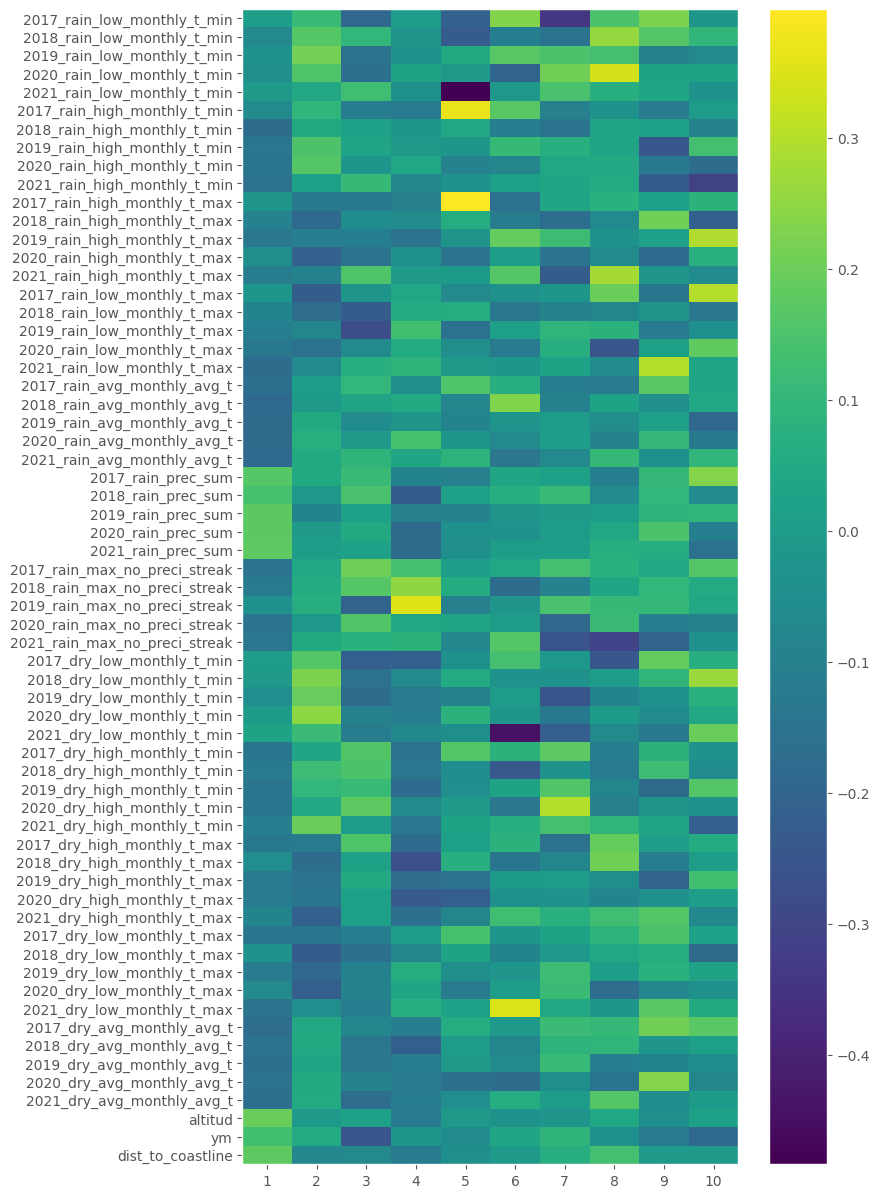

In [25]:
#Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 15))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
#plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(n_components), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.3770123  0.19871834 0.07873588 0.06387047 0.04436386 0.03052975
 0.02929537 0.02522055 0.02377114 0.01988262]


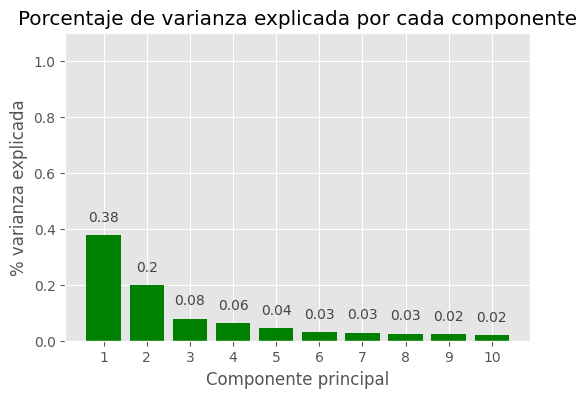

In [26]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_, color='green'
)

#for x, y in zip(np.arange(len(X_train.columns)) + 1, modelo_pca.explained_variance_ratio_):
for x, y in zip(np.arange(len(datos.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center', 
        color='black',
        alpha=0.7
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('% varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.3770123  0.57573064 0.65446653 0.718337   0.76270086 0.79323061
 0.82252598 0.84774653 0.87151767 0.89140029]


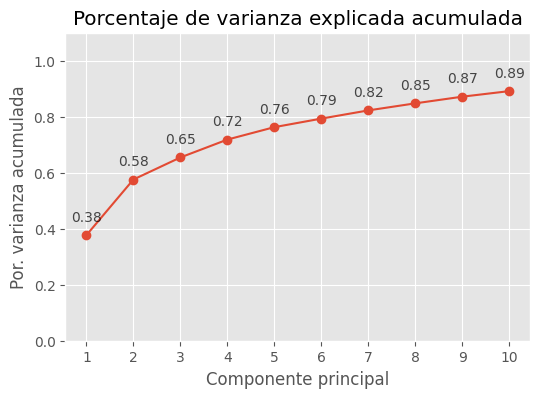

In [27]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(n_components) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(n_components) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        color='black',
        alpha=0.7
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [28]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
n = [ "PCA" + (i+1).astype("str") for i in np.arange(modelo_pca.n_components_)]
proyecciones = pca_pipe.transform(X=datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = n,
    index   = datos.index
)
proyecciones.head()

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0  10.392663 -0.207729  1.317698  0.929265 -0.863115 -0.487729  0.033765   
1  -5.053261  8.769968  4.235888 -2.347887 -1.164192  2.713194 -1.293297   
2   0.456536  4.235894 -1.203611  2.489495 -1.345832  0.650852  0.567188   
3  -1.448443  0.082693 -0.084340  3.079158 -1.332607 -1.197487  0.771056   
4  -2.344934 -3.529804 -2.336340 -1.862019 -2.219429 -1.094832 -0.402186   

       PCA8      PCA9     PCA10  
0  0.981110 -0.383924  0.450043  
1 -0.284435 -0.637538  1.288085  
2 -1.887059  0.150101 -0.790996  
3 -1.101725  0.600074  1.418269  
4  1.206427  0.183917  1.192213

In [29]:
#pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())
proyecciones.shape

(23, 10)

# PCA + Cluster

In [30]:
def silhouette_plot(X,n_cluster, plot_cluster = None):
    
    range_n_clusters = np.arange(2,n_cluster)
    score = []
    
    
    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        score.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)


        if plot_cluster:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1) = plt.subplots(1, 1)
            fig.set_size_inches(10, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
    return range_n_clusters, score

For n_clusters = 2 The average silhouette_score is : 0.36309410058745667
For n_clusters = 3 The average silhouette_score is : 0.2559350023728476
For n_clusters = 4 The average silhouette_score is : 0.2499108850988602
For n_clusters = 5 The average silhouette_score is : 0.22330726594612268
For n_clusters = 6 The average silhouette_score is : 0.21861027434721872
For n_clusters = 7 The average silhouette_score is : 0.2393714474532943
For n_clusters = 8 The average silhouette_score is : 0.22243307366492965
CPU times: user 4.76 s, sys: 1.02 s, total: 5.78 s
Wall time: 862 ms


Text(0, 0.5, 'silhouette score')

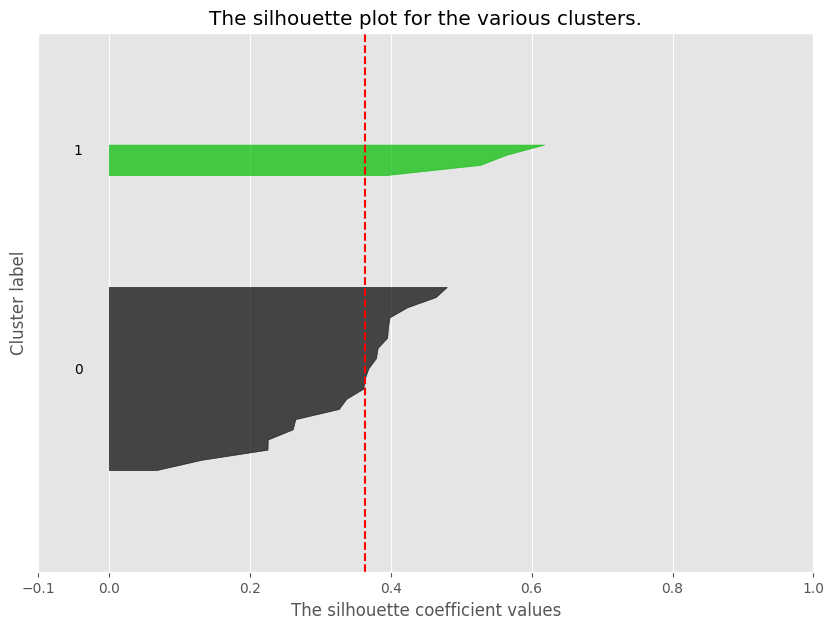

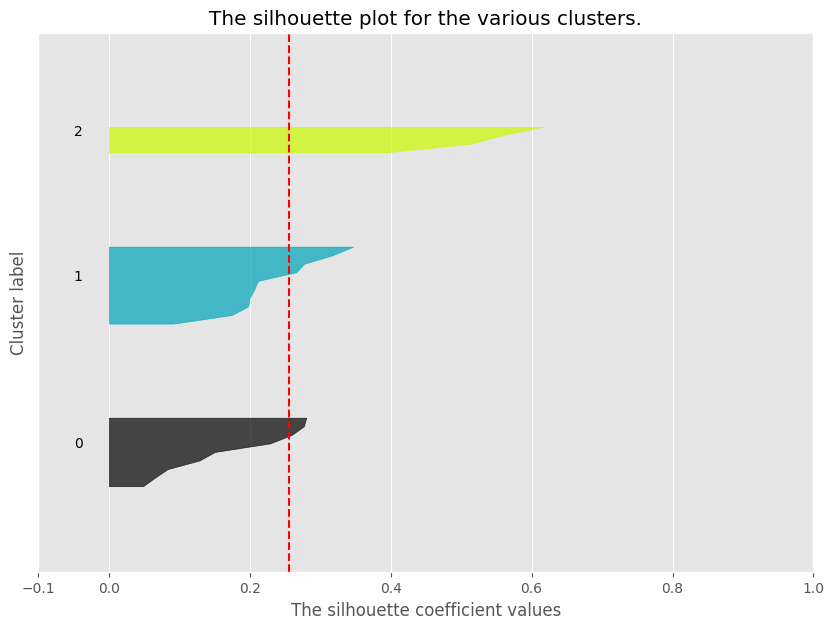

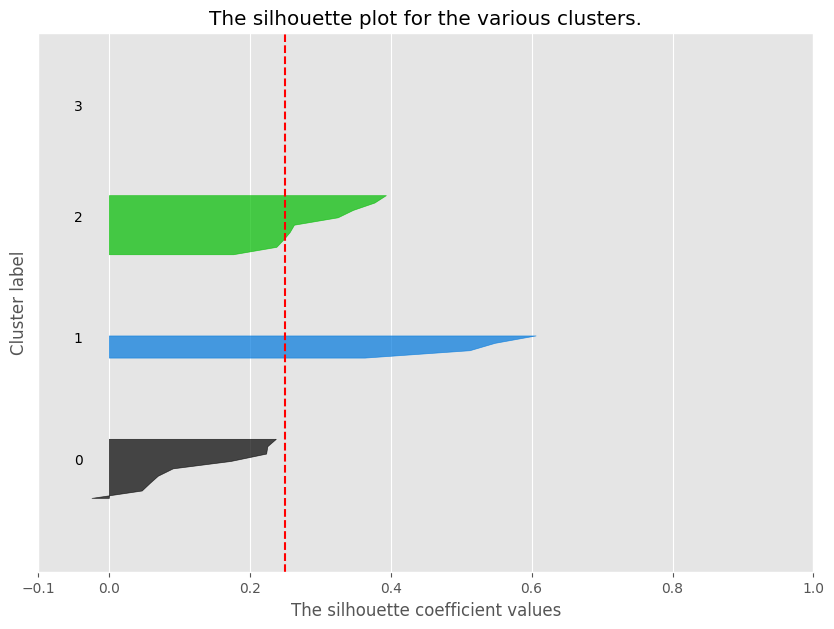

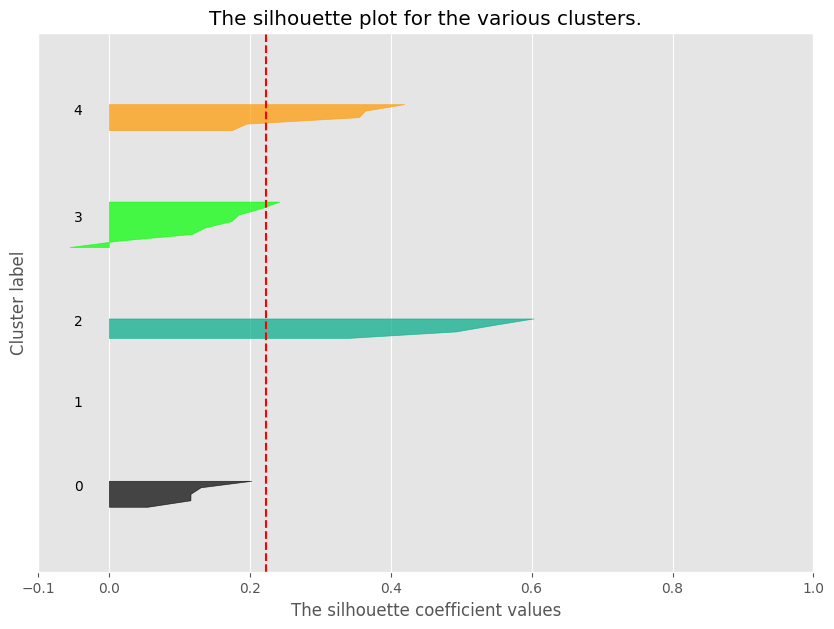

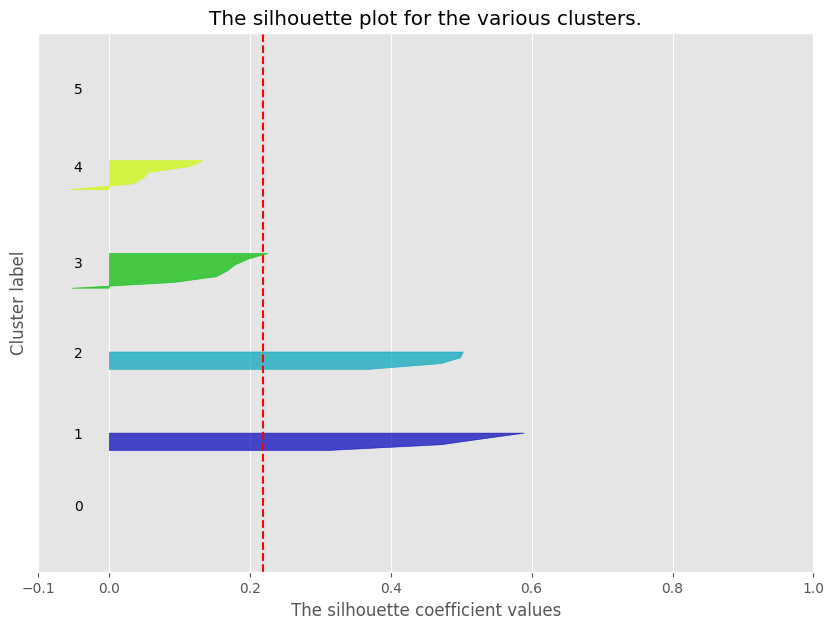

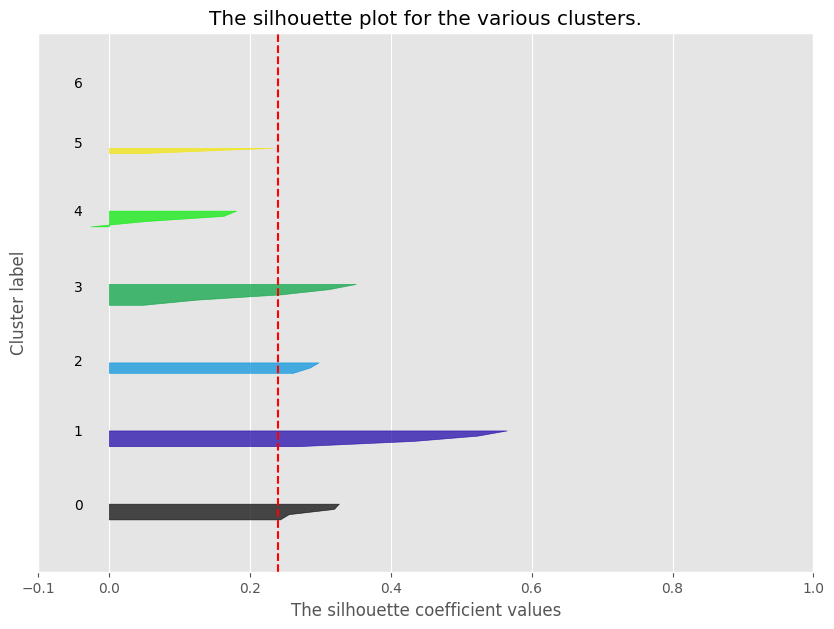

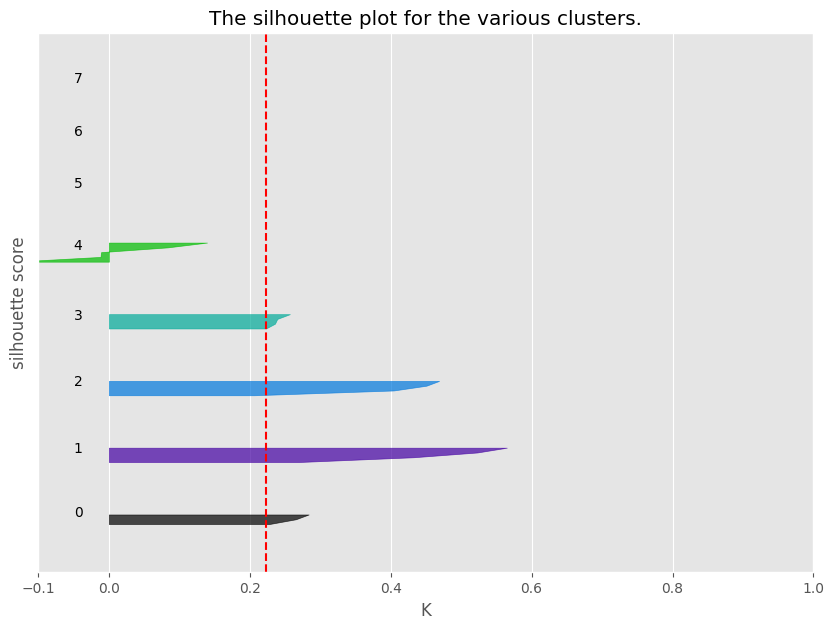

In [31]:
%%time
n_cols = 10
range_clusters, scores = silhouette_plot(np.asarray(proyecciones.iloc[:,:n_cols]),9,plot_cluster =True)
plt.plot(range_clusters,scores)
plt.xlabel('K')
plt.ylabel('silhouette score')

For n_clusters = 2 The average silhouette_score is : 0.38386277193708673
For n_clusters = 3 The average silhouette_score is : 0.2785482876512477
For n_clusters = 4 The average silhouette_score is : 0.2738739863563888
For n_clusters = 5 The average silhouette_score is : 0.2728907066668144
For n_clusters = 6 The average silhouette_score is : 0.21218796318072178
For n_clusters = 7 The average silhouette_score is : 0.24184143239477135
For n_clusters = 8 The average silhouette_score is : 0.2229297115409591
CPU times: user 4.84 s, sys: 711 ms, total: 5.55 s
Wall time: 730 ms


Text(0, 0.5, 'silhouette score')

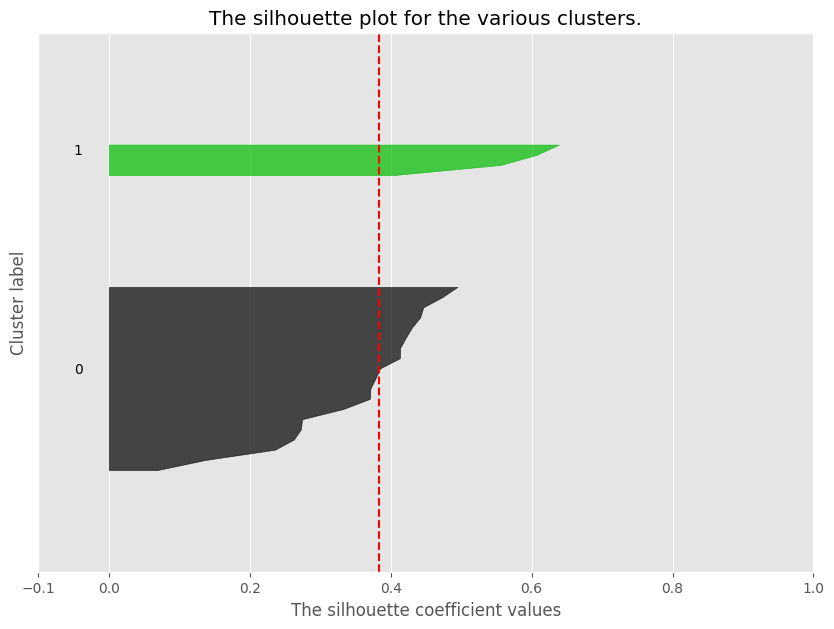

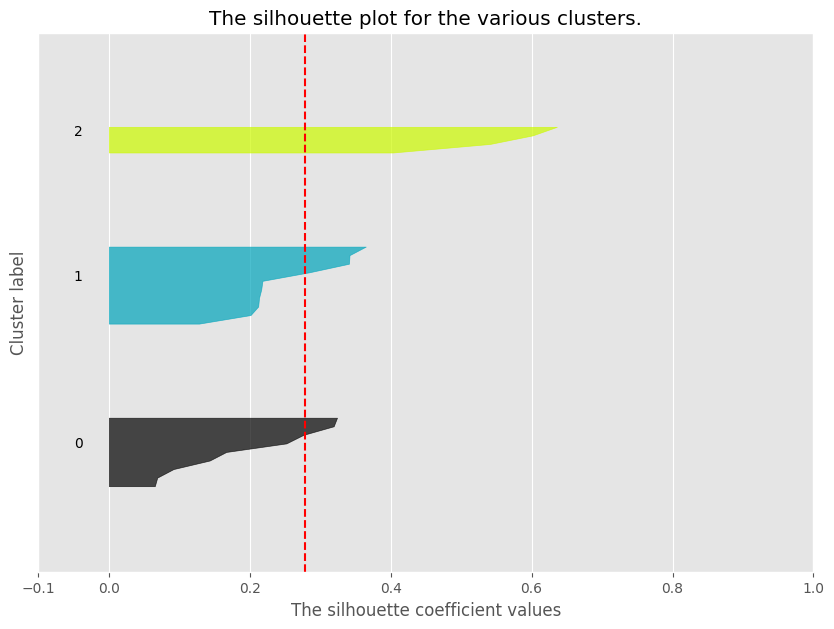

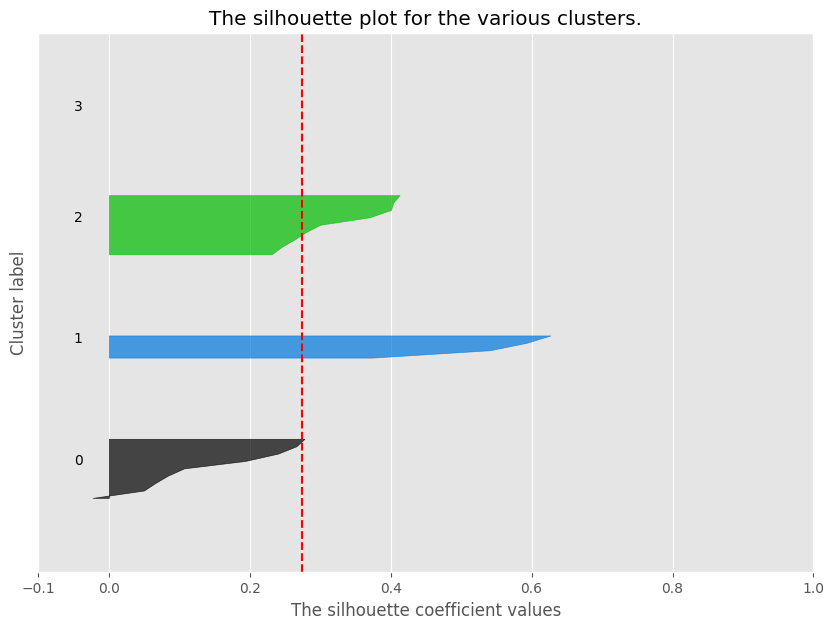

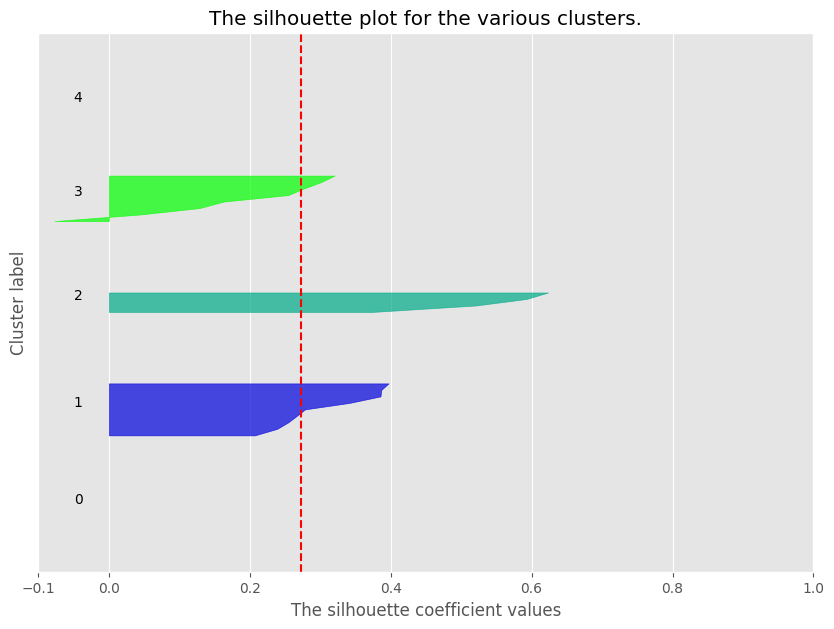

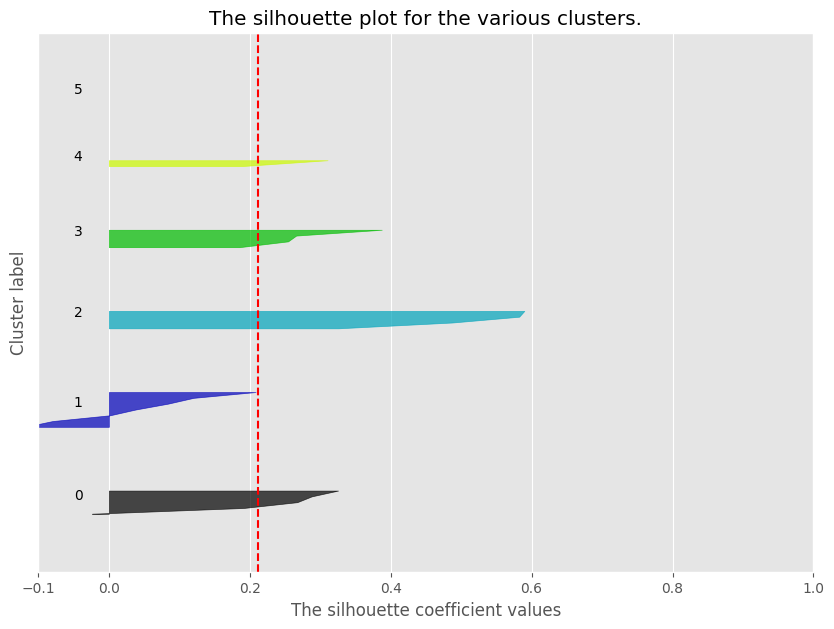

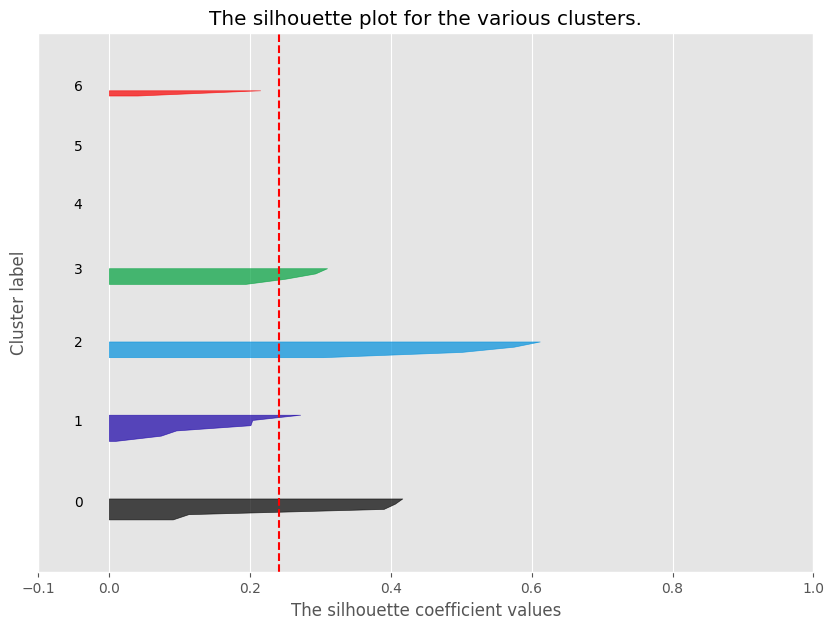

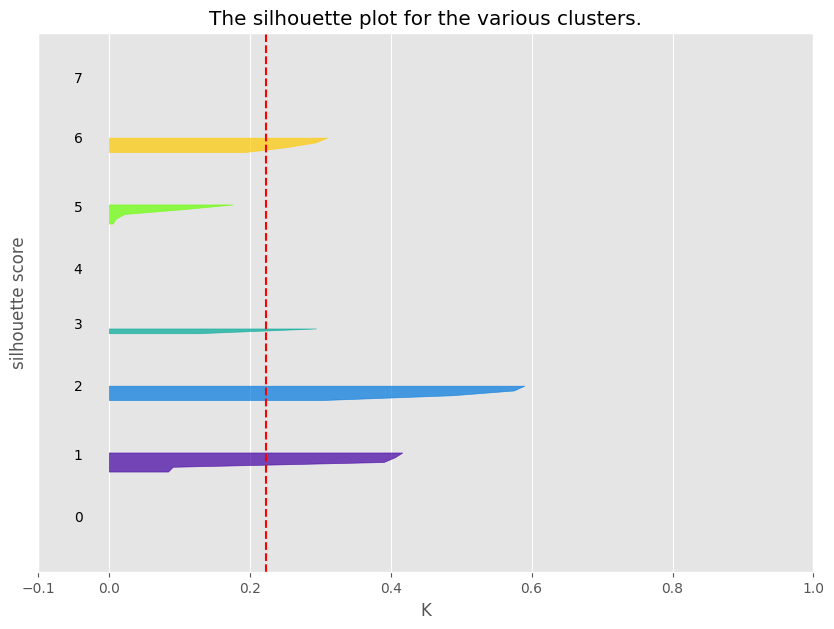

In [32]:
%%time
n_cols = 8
range_clusters, scores = silhouette_plot(np.asarray(proyecciones.iloc[:,:n_cols]),9,plot_cluster =True)
plt.plot(range_clusters,scores)
plt.xlabel('K')
plt.ylabel('silhouette score')

For n_clusters = 2 The average silhouette_score is : 0.42508950545843405
For n_clusters = 3 The average silhouette_score is : 0.31721932317298834
For n_clusters = 4 The average silhouette_score is : 0.32328490592894804
For n_clusters = 5 The average silhouette_score is : 0.3283784104795653
For n_clusters = 6 The average silhouette_score is : 0.30603521745721773
For n_clusters = 7 The average silhouette_score is : 0.32069921043996413
For n_clusters = 8 The average silhouette_score is : 0.333795741653795
CPU times: user 4.54 s, sys: 673 ms, total: 5.21 s
Wall time: 704 ms


Text(0, 0.5, 'silhouette score')

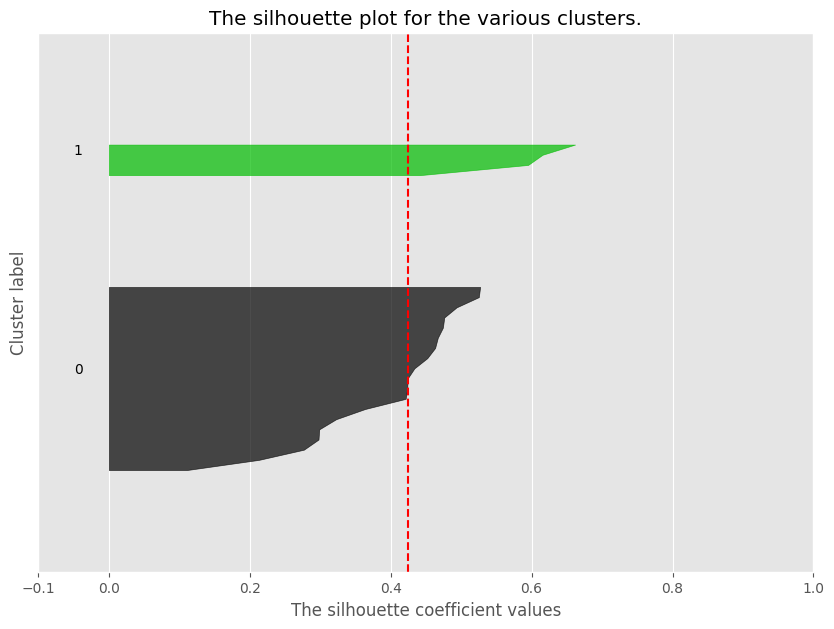

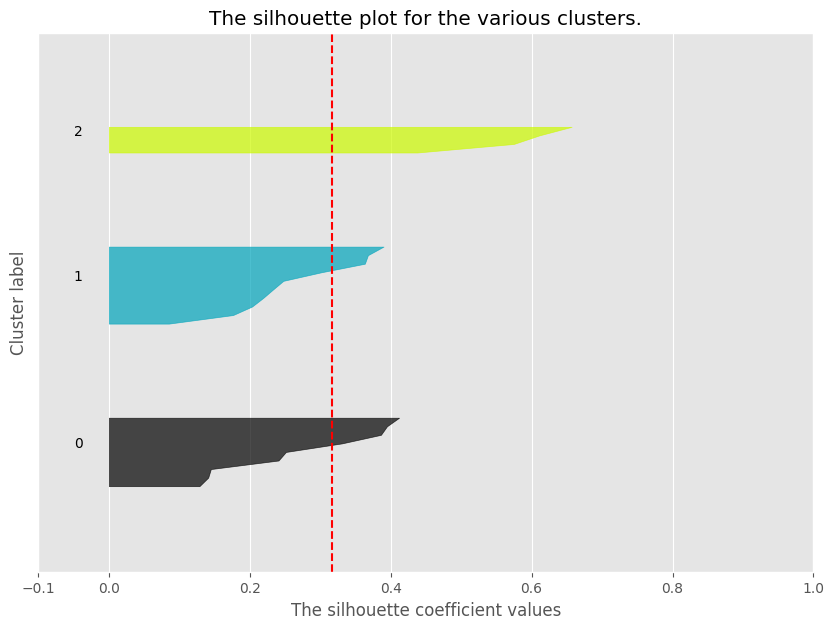

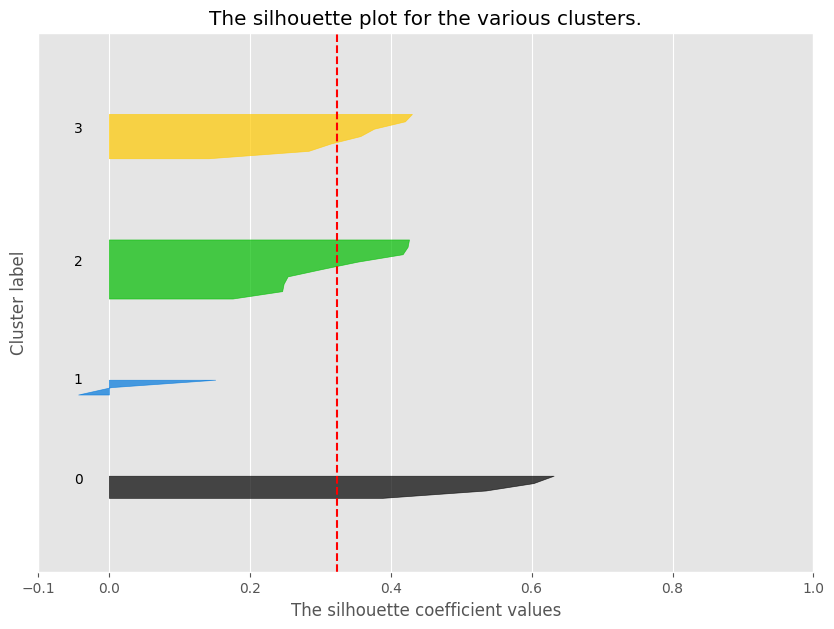

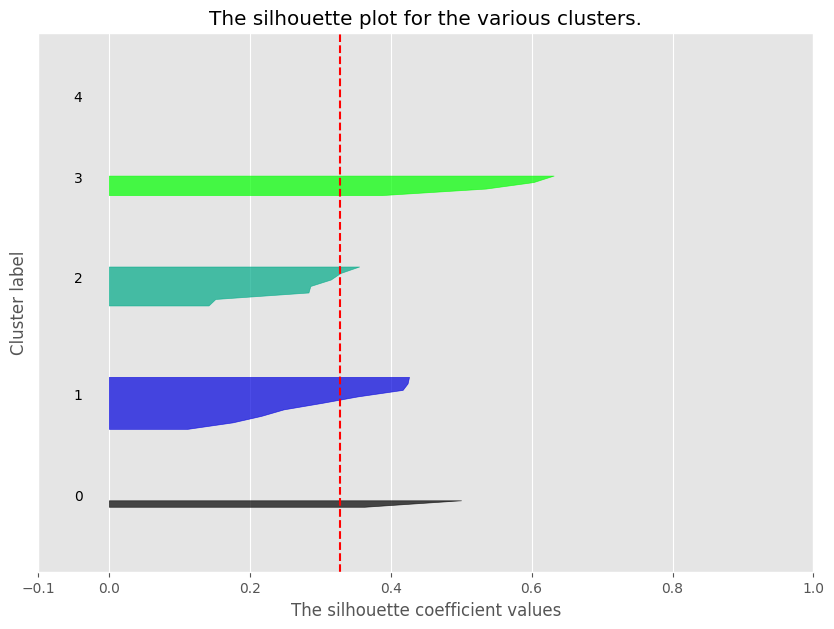

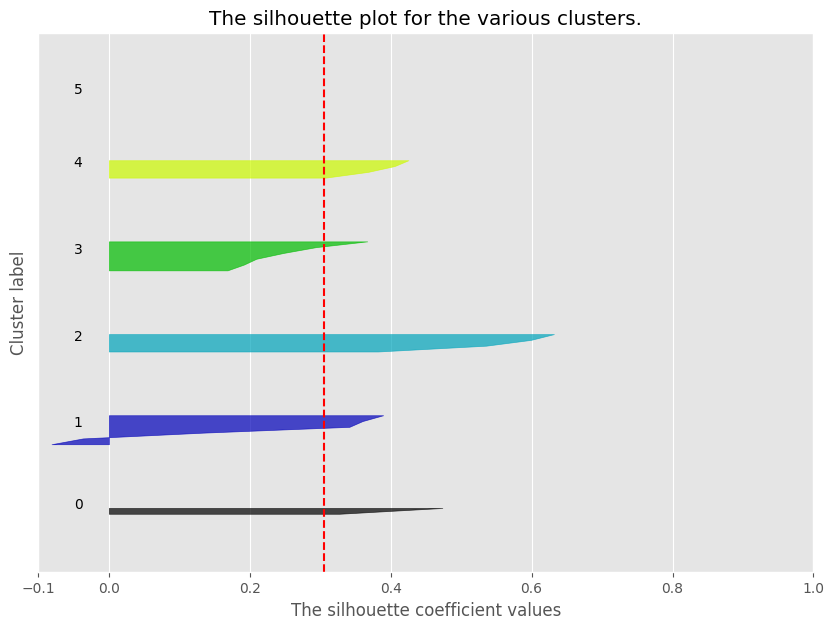

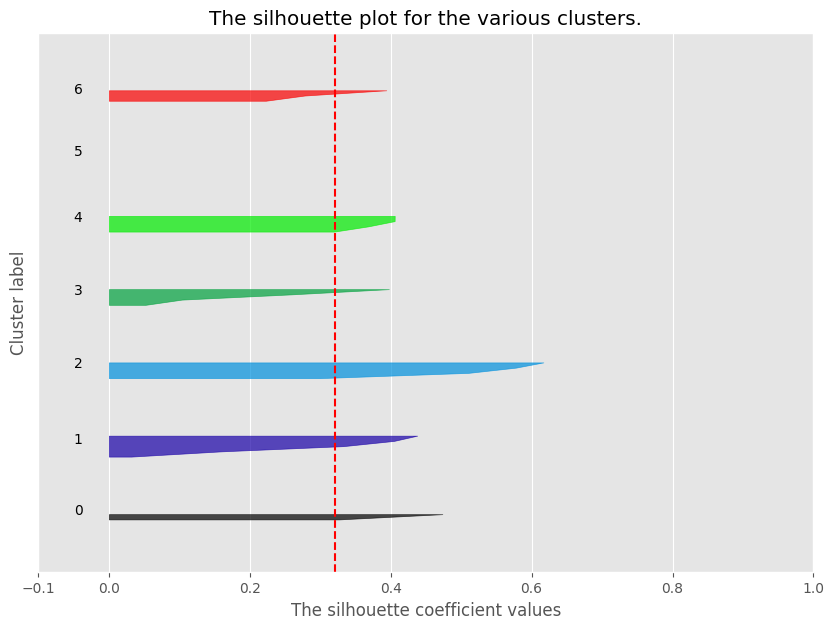

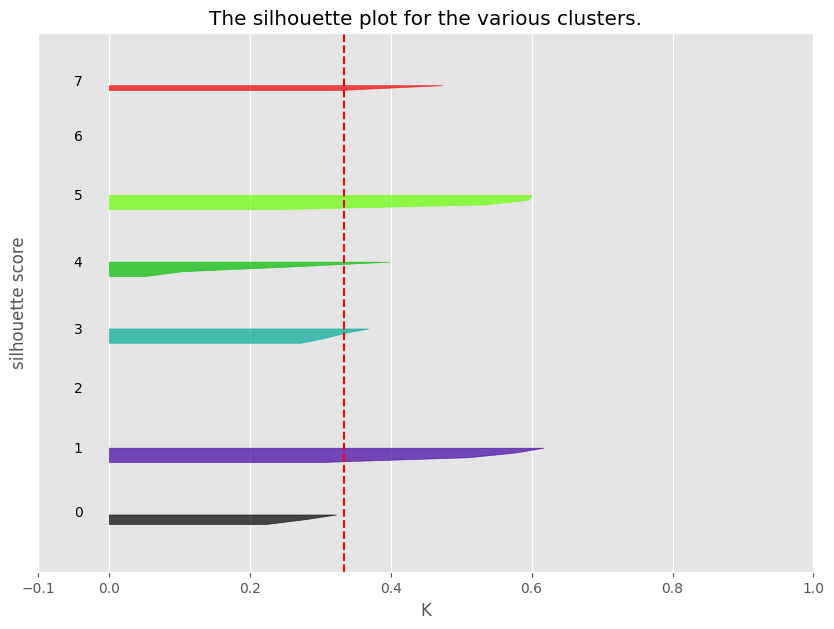

In [33]:
%%time
n_cols = 5
range_clusters, scores = silhouette_plot(np.asarray(proyecciones.iloc[:,:n_cols]),9,plot_cluster =True)
plt.plot(range_clusters,scores)
plt.xlabel('K')
plt.ylabel('silhouette score')

In [34]:
proyecciones['cluster']=KMeans(n_clusters=5, random_state=10).fit(proyecciones.iloc[:,:5])

In [35]:
proyecciones

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0   10.392663 -0.207729  1.317698  0.929265 -0.863115 -0.487729  0.033765   
1   -5.053261  8.769968  4.235888 -2.347887 -1.164192  2.713194 -1.293297   
2    0.456536  4.235894 -1.203611  2.489495 -1.345832  0.650852  0.567188   
3   -1.448443  0.082693 -0.084340  3.079158 -1.332607 -1.197487  0.771056   
4   -2.344934 -3.529804 -2.336340 -1.862019 -2.219429 -1.094832 -0.402186   
5   -0.292545 -6.802175  0.674217  0.764716  1.699593  0.693367  0.076909   
6   -2.381199  3.174879 -2.472496 -0.351812 -1.439171 -0.576121  0.911277   
7   -1.643033 -0.135081 -0.088280  1.581624  1.275811 -0.228201 -0.185535   
8   -3.449067  3.748122 -3.189042 -0.547959  5.514071 -0.472700 -2.309716   
9   -5.383196 -1.527555  5.027347 -2.537114  2.194019 -2.207952  3.255191   
10  -2.523392  3.186176 -2.909205 -0.303638 -0.732751 -0.602459  0.181343   
11  -0.844349  2.227049 -3.065887  0.107546 -0.920848 -0.769560  0.829264   
12  13.032885  2.765861  1.949335 -1.290693 -0.276548  0.031151 -0.024444   
13  -0.876114 -1.123561 -2.740032 -2.006362 -0.635624  0.670087  1.293769   
14   7.865536 -1.052343  1.071297 -0.184117  0.193134 -0.788886 -1.437379   
15  -5.703397 -1.223136  1.750826 -1.718953 -0.803151  0.952910 -0.308558   
16  -3.745065 -6.493884  0.907554  0.649567 -1.664923  1.167239 -2.896836   
17  -3.823527  1.004078  1.423744  2.174644 -0.662798 -0.460595  0.911824   
18   2.001828 -1.926511 -0.421145 -2.969721 -0.678001 -2.284706 -1.062194   
19  -1.678415 -3.783021  0.514303 -0.636220 -0.087264  0.267080 -1.145337   
20  -0.838607  1.798038  2.294960  5.295948  0.990733 -1.179847 -0.846025   
21   1.583281 -4.011158 -1.364180  1.548622  1.106390  3.802266  2.320122   
22   6.695812  0.823200 -1.292610 -1.864089  1.852504  1.402928  0.759800   

        PCA8      PCA9     PCA10                                cluster  
0   0.981110 -0.383924  0.450043  KMeans(n_clusters=5, random_state=10)  
1  -0.284435 -0.637538  1.288085  KMeans(n_clusters=5, random_state=10)  
2  -1.887059  0.150101 -0.790996  KMeans(n_clusters=5, random_state=10)  
3  -1.101725  0.600074  1.418269  KMeans(n_clusters=5, random_state=10)  
4   1.206427  0.183917  1.192213  KMeans(n_clusters=5, random_state=10)  
5  -1.409172 -2.343396  1.581973  KMeans(n_clusters=5, random_state=10)  
6  -1.464842 -2.617483 -1.519747  KMeans(n_clusters=5, random_state=10)  
7  -1.278074  2.942965  0.902434  KMeans(n_clusters=5, random_state=10)  
8   0.091332  0.471447 -0.209543  KMeans(n_clusters=5, random_state=10)  
9  -0.756470 -0.126991 -0.835748  KMeans(n_clusters=5, random_state=10)  
10  0.745576 -0.493212 -0.872763  KMeans(n_clusters=5, random_state=10)  
11  0.744154  0.085902 -0.429373  KMeans(n_clusters=5, random_state=10)  
12 -0.267727  1.812341 -1.201155  KMeans(n_clusters=5, random_state=10)  
13  0.645041  0.609499  2.484683  KMeans(n_clusters=5, random_state=10)  
14  0.259895 -1.720705  0.725334  KMeans(n_clusters=5, random_state=10)  
15  2.643443  0.653623 -0.317898  KMeans(n_clusters=5, random_state=10)  
16 -2.168612  0.717074 -1.116751  KMeans(n_clusters=5, random_state=10)  
17 -0.172378  0.925774  0.164717  KMeans(n_clusters=5, random_state=10)  
18 -0.246032  1.016740 -0.491379  KMeans(n_clusters=5, random_state=10)  
19  0.930855 -0.785319 -1.897815  KMeans(n_clusters=5, random_state=10)  
20  2.463184 -0.953084  0.150865  KMeans(n_clusters=5, random_state=10)  
21  1.279141  0.653647 -1.328351  KMeans(n_clusters=5, random_state=10)  
22 -0.953633 -0.761452  0.652903  KMeans(n_clusters=5, random_state=10)

In [36]:
pipeline_model = make_pipeline(KMeans(n_clusters=7, random_state=10))
pipeline_model.fit(proyecciones.iloc[:,:5])
proyecciones['cluster']=pipeline_model.predict(proyecciones.iloc[:,:5])

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

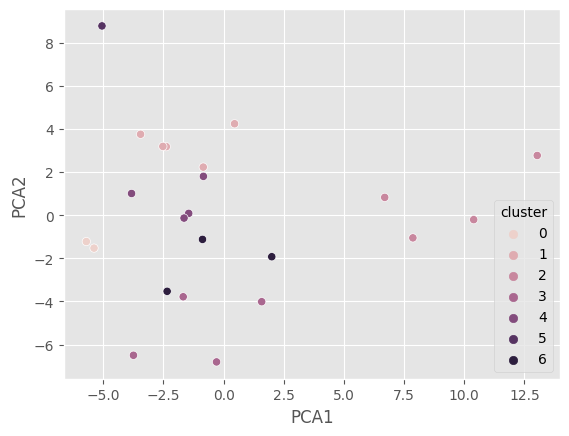

In [37]:
sns.scatterplot(hue="cluster", x='PCA1',y ="PCA2",  data=proyecciones)

<AxesSubplot:xlabel='PCA1', ylabel='PCA3'>

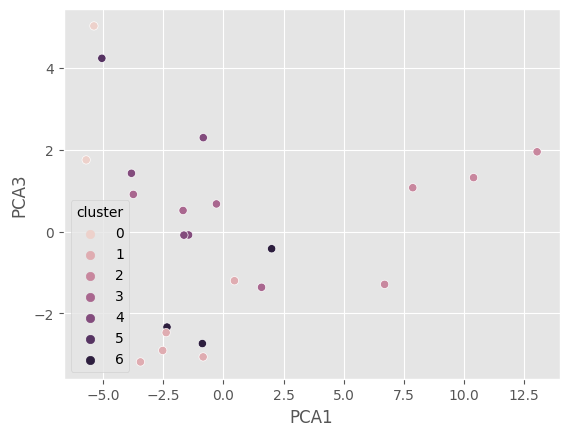

In [38]:
sns.scatterplot(hue="cluster", x='PCA1',y ="PCA3",  data=proyecciones)

# seleccion_modelo

In [39]:
# best model
#kmeans1 = pipeline_model = make_pipeline(StandardScaler(), PCA(n_components = 5), KMeans(n_clusters=6, random_state=10))
#kmeans2  = pipeline_model = make_pipeline(StandardScaler(), PCA(n_components = 5), KMeans(n_clusters=6, random_state=10))
#kmeans3 pipeline_model = make_pipeline(StandardScaler(), PCA(n_components = 5), KMeans(n_clusters=8, random_state=10))
#pipeline_model = make_pipeline(StandardScaler(), PCA(n_components = 5), KMeans(n_clusters=7, random_state=10))
pipeline_model = make_pipeline(StandardScaler(), PCA(n_components = 5), KMeans(n_clusters=5, random_state=10))
pipeline_model.fit(datos)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('kmeans', KMeans(n_clusters=5, random_state=10))])

In [40]:
filename = 'model_cluster_5a_coastline.joblib'
jl.dump(pipeline_model, filename)

['model_cluster_5a_coastline.joblib']

In [41]:
datos['cluster']=pipeline_model.predict(datos)

In [42]:
features[['estacion']].merge(datos[['cluster']], how='inner', left_index=True, right_index=True)

estacion  cluster
0    CENCEN        3
1    ICCCDL        4
2    ICCCHI        1
3    LUTBON        1
4    LUTTEH        2
5    MAGBOU        2
6    MAGPVD        1
7    MAGSAV        1
8    MAGSNC        1
9    MAGTMG        0
10   MAGXOL        1
11   MATPEO        1
12   PAGLOR        3
13   PAGNRJ        2
14   PANBAL        3
15   PANSRF        0
16   SAAAMA        2
17   SAALGR        1
18   SDTCBR        2
19   SDTTRI        2
20   TBUIRL        1
21   TBUPUY        2
22   TULTLA        3

In [43]:
features = features.merge(datos[['cluster']], how='inner', left_index=True, right_index=True)
features

estacion  2017_rain_low_monthly_t_min  2018_rain_low_monthly_t_min  \
0    CENCEN                         19.0                         20.0   
1    ICCCDL                         22.0                         22.0   
2    ICCCHI                         20.0                         20.0   
3    LUTBON                         20.0                         20.0   
4    LUTTEH                         20.0                         21.0   
5    MAGBOU                         15.0                         18.0   
6    MAGPVD                         20.0                         20.0   
7    MAGSAV                         20.0                         20.0   
8    MAGSNC                         21.0                         20.0   
9    MAGTMG                         12.0                         20.0   
10   MAGXOL                         20.0                         21.0   
11   MATPEO                         21.0                         20.0   
12   PAGLOR                         20.0                         20.0   
13   PAGNRJ                         20.0                         20.0   
14   PANBAL                         20.0                         20.0   
15   PANSRF                         21.0                         21.0   
16   SAAAMA                         20.0                         20.0   
17   SAALGR                         20.0                         21.0   
18   SDTCBR                         20.0                         20.0   
19   SDTTRI                         20.0                         19.0   
20   TBUIRL                         18.0                         21.0   
21   TBUPUY                         20.0                         19.0   
22   TULTLA                         19.0                         19.0   

    2019_rain_low_monthly_t_min  2020_rain_low_monthly_t_min  \
0                          18.0                         20.0   
1                          22.0                         20.0   
2                          20.0                         21.0   
3                          19.0                         22.0   
4                          18.0                         21.0   
5                          18.0                         17.0   
6                          22.0                         22.0   
7                          19.0                         20.0   
8                          21.0                         22.0   
9                          18.0                         20.0   
10                         22.0                         21.0   
11                         21.0                         22.0   
12                         20.0                         19.0   
13                         20.0                         21.0   
14                         17.0                         20.0   
15                         20.0                         22.0   
16                         16.0                         16.0   
17                         18.0                         21.0   
18                         18.0                         20.0   
19                         18.0                         20.0   
20                         20.0                         21.0   
21                         20.0                         20.0   
22                         20.0                         20.0   

    2021_rain_low_monthly_t_min  2017_rain_high_monthly_t_min  \
0                          20.0                          24.0   
1                          22.0                          27.0   
2                          21.0                          26.0   
3                          20.0                          25.0   
4                          21.0                          25.0   
5                          16.0                          25.0   
6                          21.0                          26.0   
7                          20.0                          25.0   
8                          12.0                          30.0   
9                          20.0                          26.0  

In [44]:
s = features.cluster
counts = s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, '%': percent100})

counts      %
1       9  39.1%
2       7  30.4%
3       4  17.4%
0       2   8.7%
4       1   4.3%

In [45]:
set(s)

{0, 1, 2, 3, 4}

## Caracterizacion

In [46]:
features.columns

Index(['estacion', '2017_rain_low_monthly_t_min',
       '2018_rain_low_monthly_t_min', '2019_rain_low_monthly_t_min',
       '2020_rain_low_monthly_t_min', '2021_rain_low_monthly_t_min',
       '2017_rain_high_monthly_t_min', '2018_rain_high_monthly_t_min',
       '2019_rain_high_monthly_t_min', '2020_rain_high_monthly_t_min',
       '2021_rain_high_monthly_t_min', '2017_rain_high_monthly_t_max',
       '2018_rain_high_monthly_t_max', '2019_rain_high_monthly_t_max',
       '2020_rain_high_monthly_t_max', '2021_rain_high_monthly_t_max',
       '2017_rain_low_monthly_t_max', '2018_rain_low_monthly_t_max',
       '2019_rain_low_monthly_t_max', '2020_rain_low_monthly_t_max',
       '2021_rain_low_monthly_t_max', '2017_rain_avg_monthly_avg_t',
       '2018_rain_avg_monthly_avg_t', '2019_rain_avg_monthly_avg_t',
       '2020_rain_avg_monthly_avg_t', '2021_rain_avg_monthly_avg_t',
       '2017_rain_prec_sum', '2018_rain_prec_sum', '2019_rain_prec_sum',
       '2020_rain_prec_sum', '2021_rain

In [57]:
col_important = [
       '2017_rain_prec_sum', '2018_rain_prec_sum', '2019_rain_prec_sum',
       '2020_rain_prec_sum', '2021_rain_prec_sum',
       '2017_rain_max_no_preci_streak', '2018_rain_max_no_preci_streak',
       '2019_rain_max_no_preci_streak', '2020_rain_max_no_preci_streak',
       '2021_rain_max_no_preci_streak', '2017_dry_low_monthly_t_min',  'altitud', 
       'ym', 'dist_to_coastline']

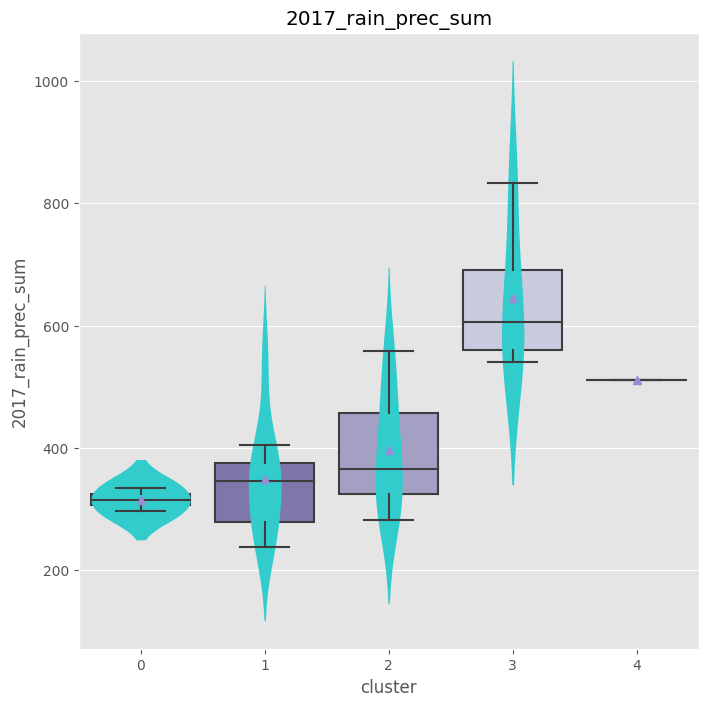

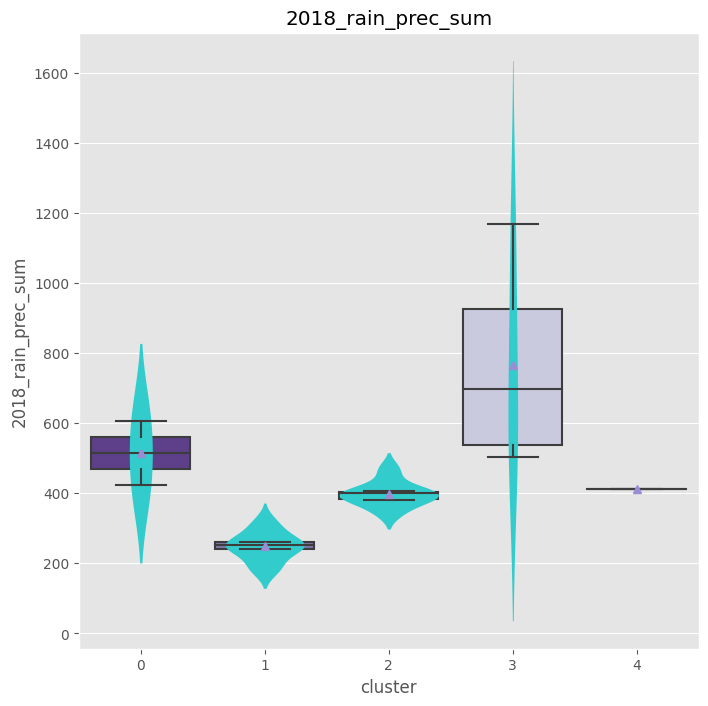

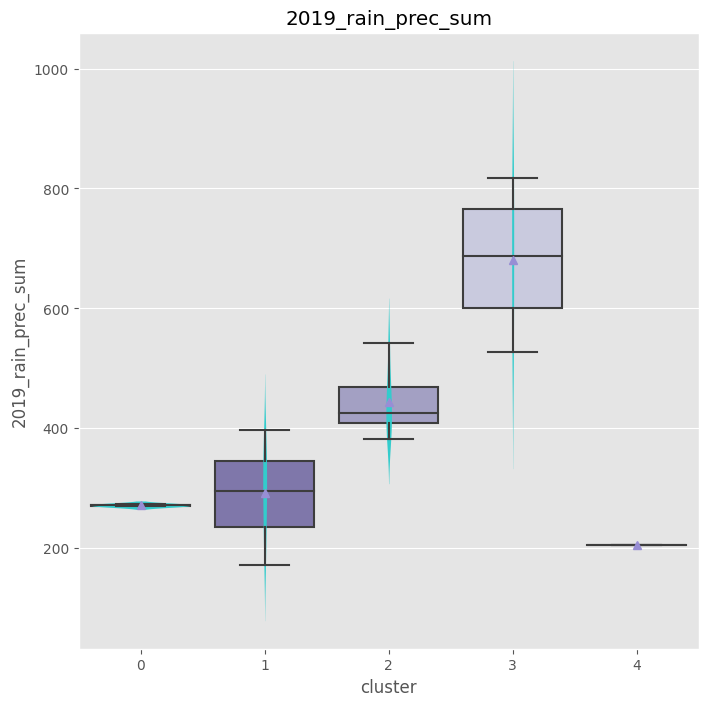

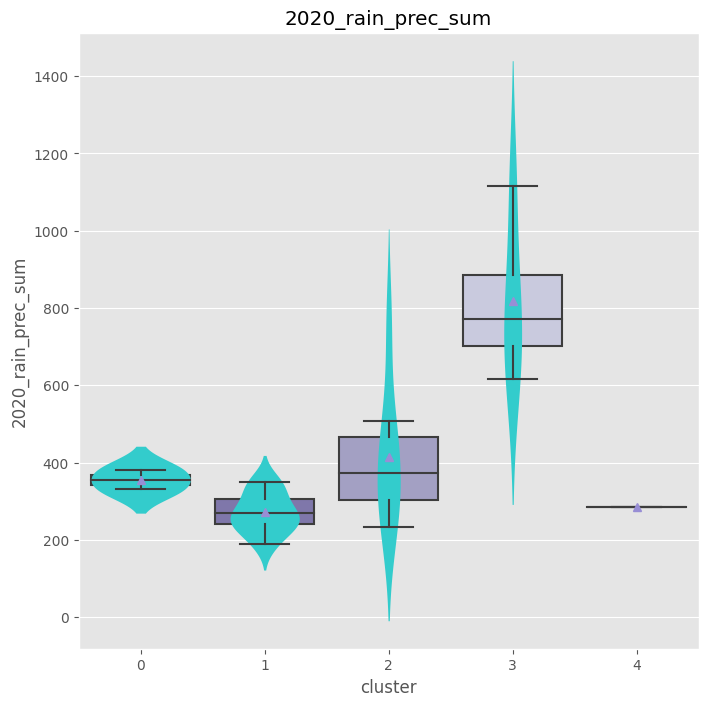

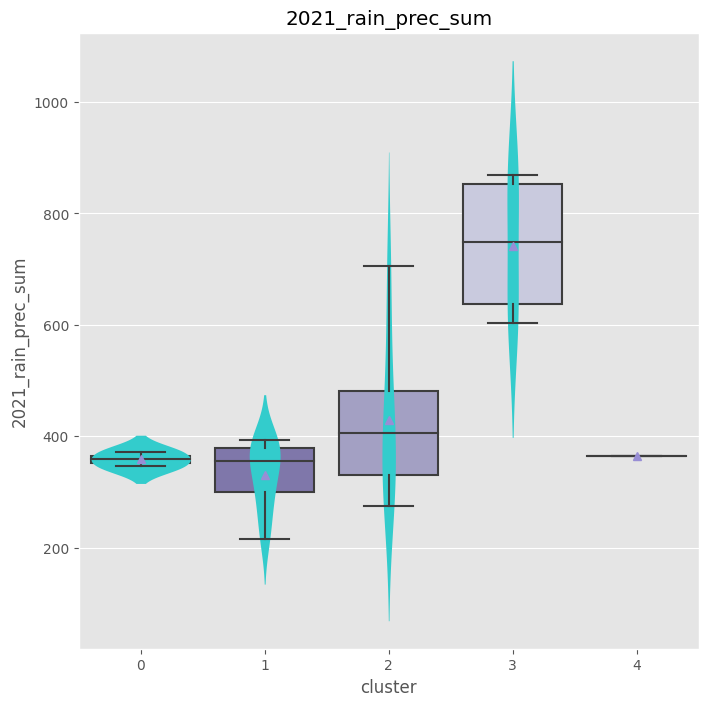

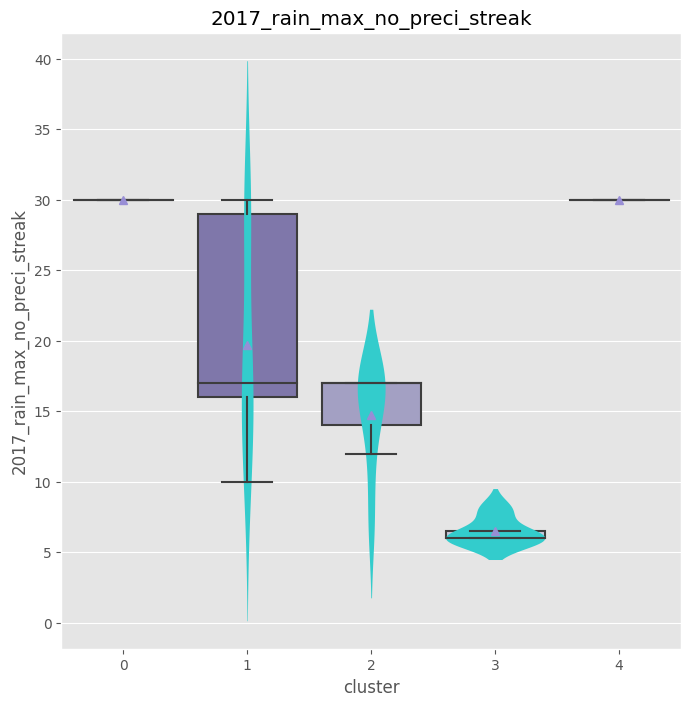

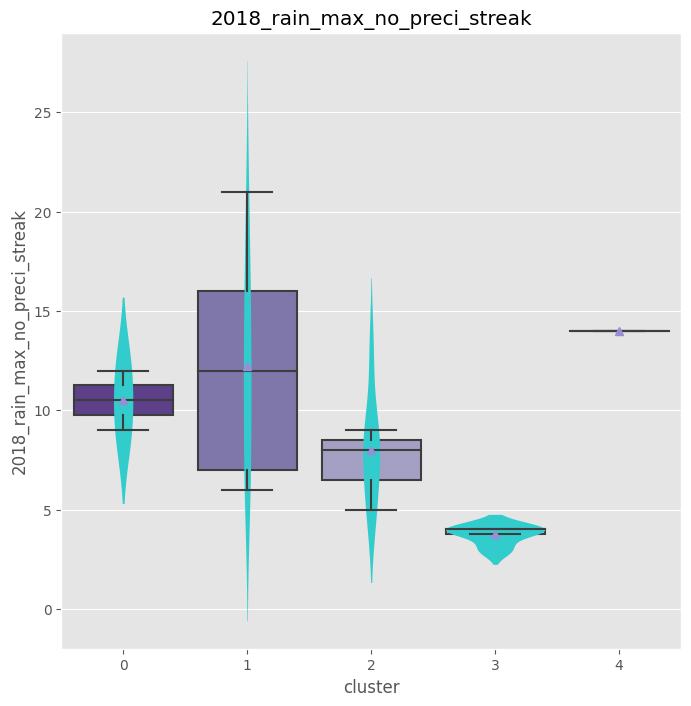

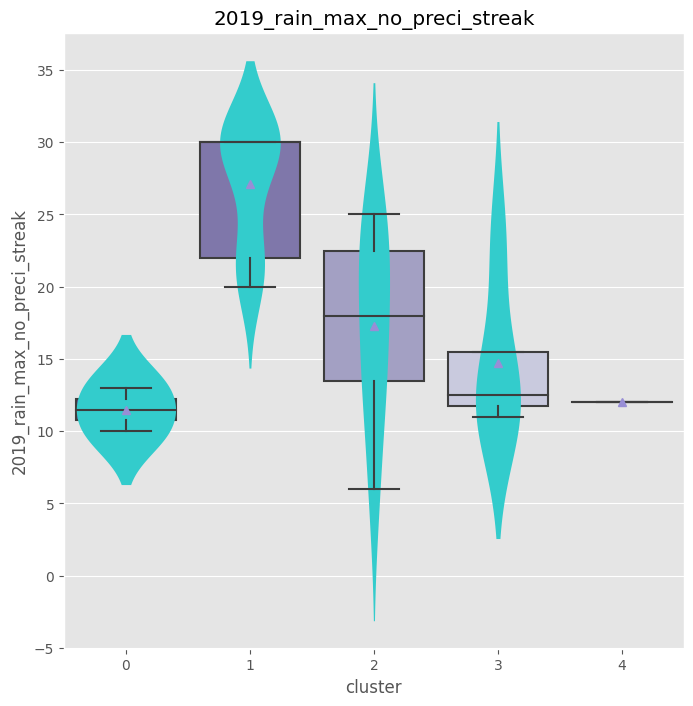

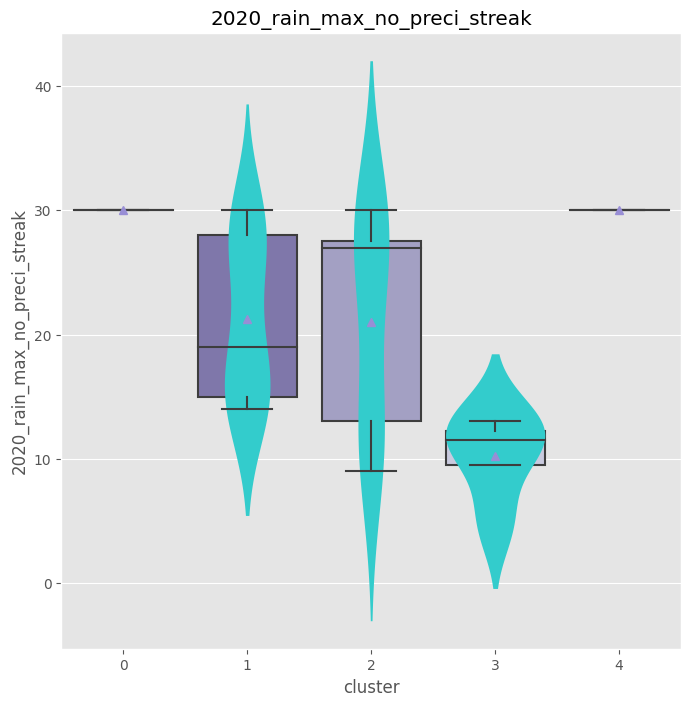

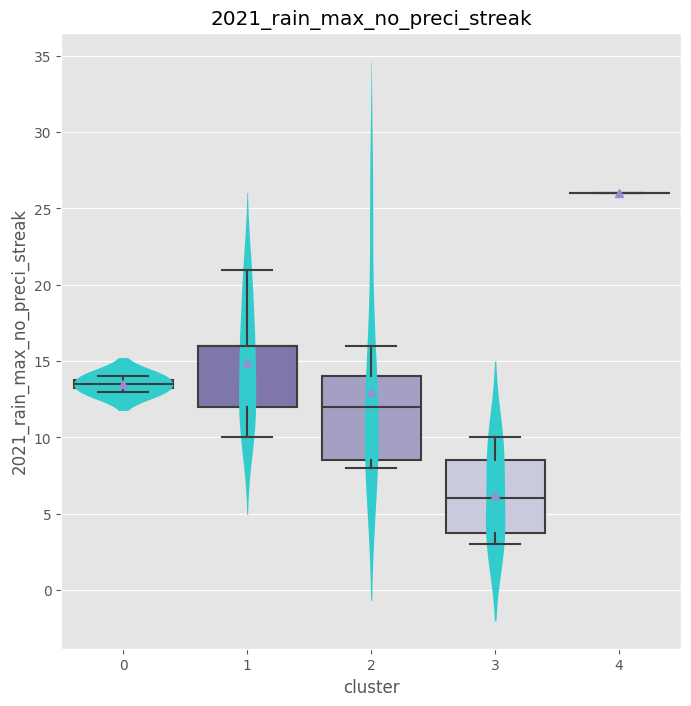

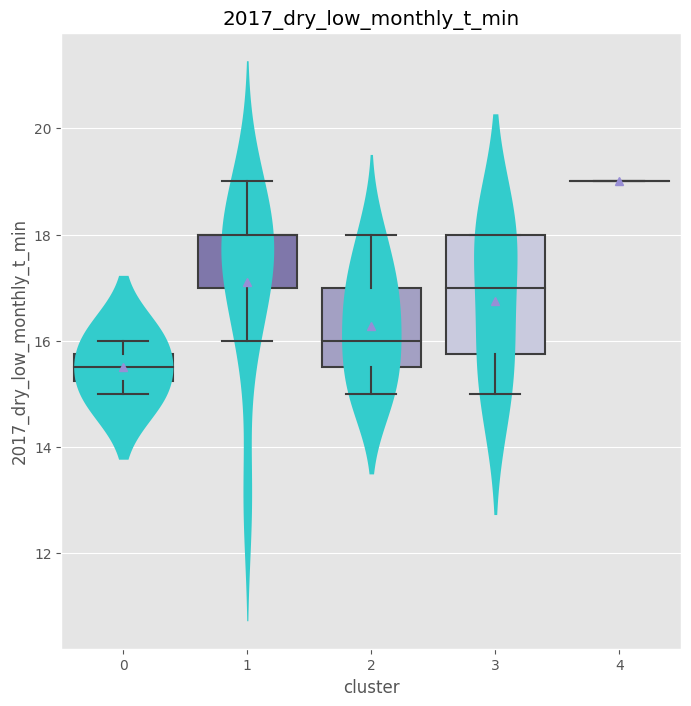

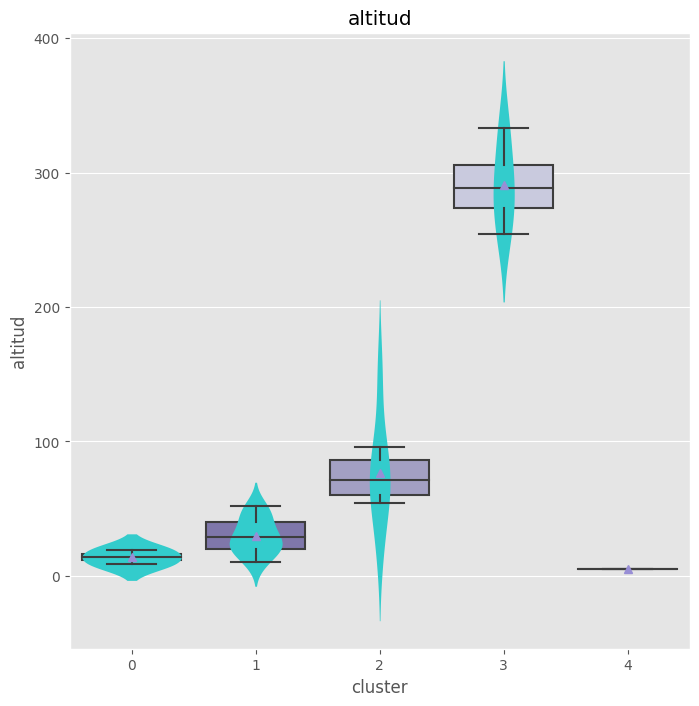

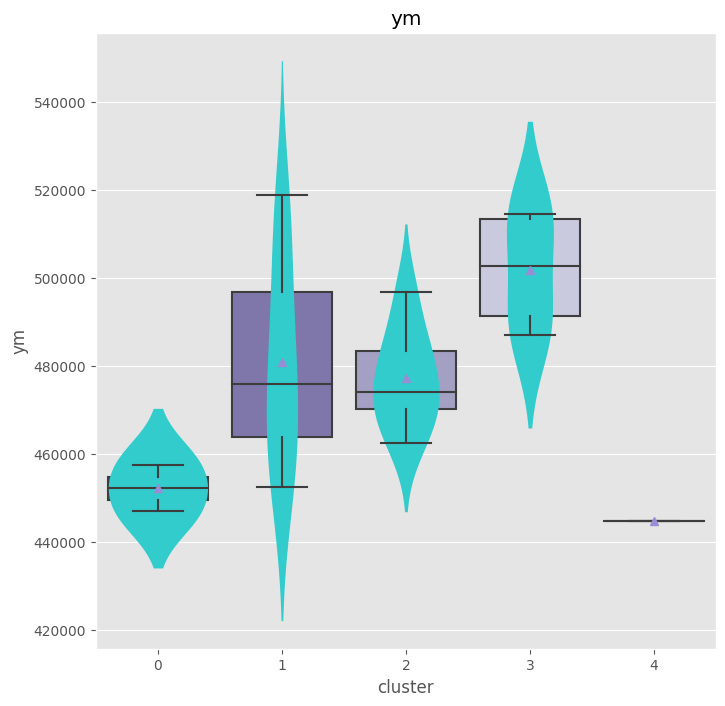

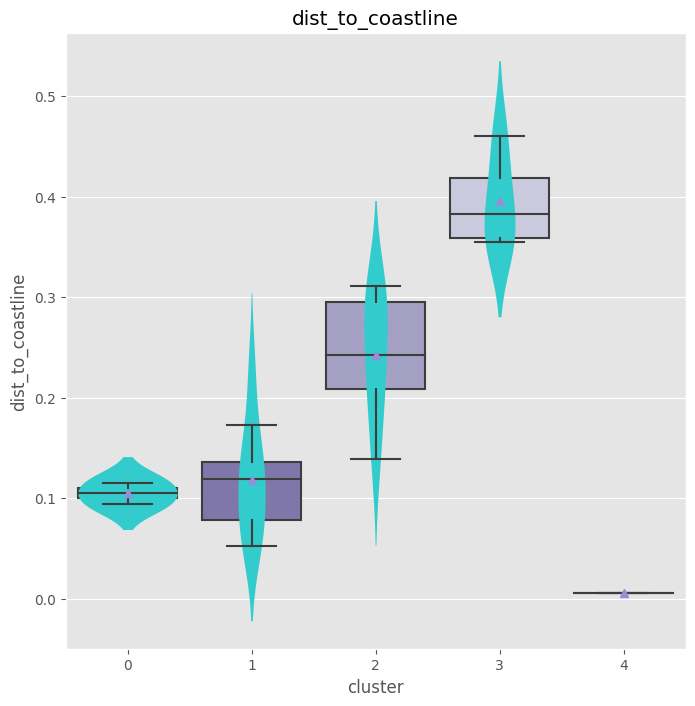

In [58]:
for i in col_important:
    plt.figure(figsize = (8,8))
    plt.title(i)
    ax = sns.violinplot(data=features, x='cluster', y=i, color="cyan", showfliers=False,inner=None, linewidth=0, saturation=0.6, alpha=.3)
    g = sns.boxplot(x = 'cluster', y =i,palette = "Purples_r" ,showmeans=True,
                data = datos, showfliers=False)
    plt.show()




In [59]:
features = features[['estacion', 'latitud', 'longitud']].merge(datos, how='inner', left_index=True, right_index=True)

In [60]:
features.cluster.value_counts()

1    9
2    7
3    4
0    2
4    1
Name: cluster, dtype: int64

In [61]:
#Create the Map
map_squema = folium.Map(
    location = [14.38100, -90.6],
    zoom_start = 8
)


In [62]:
#You Markler the point in Map
for indice, row in features.iterrows():
    if row['cluster']==0:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='purple', icon_color='purple')
        ).add_to(map_squema)
    elif row['cluster']==1:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='blue', icon_color='cyan')
        ).add_to(map_squema)
    elif row['cluster']==2:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='lightgray', icon_color='lightgray')
        ).add_to(map_squema)
    elif row['cluster']==3:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='beige', icon_color='beige')
        ).add_to(map_squema)
    elif row['cluster']==4:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='lightgreen', icon_color='lightgreen')
        ).add_to(map_squema)
    elif row['cluster']==5:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='lightred', icon_color='lightred')
        ).add_to(map_squema)
    else:
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='black', icon_color='white')
        ).add_to(map_squema)
map_squema

# comparacion con carlos ICC

In [63]:
df_general = pd.read_excel('/home/diana/Escritorio/CIAT/ICC/20211103 - Información general REDMET.xlsx', 'Hoja1')
df_general = df_general[['Codigo', 'Latitud', 'Longitud','Altitud\n(msnm)', 'Estrato']]
df_general = df_general.replace(r'\W+', '', regex=True)
df_general.columns=['estacion', 'latitud', 'longitud','altitud', 'estrato']
df_general = df_general.head(38)
df_general = df_general[df_general.estacion.isin(['CENCEN', 'ICCALA', 'ICCCDL', 'ICCCHI', 'ICCCON', 'LUTBON',
       'LUTTEH', 'MAGBOU', 'MAGPVD', 'MAGSAV', 'MAGSNC', 'MAGTMG',
       'MAGXOL', 'MATPEO', 'PAGCOC', 'PAGLOR', 'PAGNRJ', 'PANBAL',
       'PANSRF', 'SAAAMA', 'SAALGR', 'SAALMQ', 'SDTCBR', 'SDTTRI',
       'TBUIRL', 'TBUPUY', 'TULTLA'])]

In [64]:
#Create the Map
map_squema = folium.Map(
    location = [14.38100, -90.6],
    zoom_start = 8
)


In [65]:
df_general.estrato.unique()

array(['Medio', 'Bajo', 'Litoral', 'Alto'], dtype=object)

In [66]:
#You Markler the point in Map
for indice, row in df_general.iterrows():
    if row['estrato']== 'Alto':
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='purple', icon_color='purple')
        ).add_to(map_squema)
    if row['estrato']== 'Medio':
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='blue', icon_color='cyan')
        ).add_to(map_squema)
    if row['estrato']== 'Bajo':
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='lightgray', icon_color='lightgray')
        ).add_to(map_squema)
    if row['estrato']== 'Litoral':
        folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=row['estacion'],
        #icon=folium.map.Icon(color='yellow'),
        icon=folium.Icon(color='pink', icon_color='pink')
        ).add_to(map_squema)

map_squema

In [67]:
monthly_data = pd.read_parquet('monthly_data_5a.parquet')
monthly_data = monthly_data.merge(features[['estacion','latitud','longitud', 'altitud', 'cluster']], how='left', on='estacion')

In [68]:
monthly_data

estacion year-month month  year  low_monthly_t_min  high_monthly_t_min  \
0      CENCEN    2017-01    01  2017               15.6                21.2   
1      CENCEN    2017-02    02  2017               17.4                22.2   
2      CENCEN    2017-03    03  2017               18.5                22.8   
3      CENCEN    2017-04    04  2017               19.0                23.0   
4      CENCEN    2017-05    05  2017               21.3                23.8   
...       ...        ...   ...   ...                ...                 ...   
1435   TULTLA    2021-08    08  2021               20.6                23.2   
1436   TULTLA    2021-09    09  2021               20.3                23.1   
1437   TULTLA    2021-10    10  2021               20.9                23.4   
1438   TULTLA    2021-11    11  2021               18.1                21.7   
1439   TULTLA    2021-12    12  2021               19.1                22.7   

      high_monthly_t_max  low_monthly_t_max  avg_monthly_avg_t  \
0                   33.4               29.0          24.379200   
1                   35.4               30.2          25.201004   
2                   36.2               29.5          26.113743   
3                   35.9               33.3          26.813264   
4                   33.8               28.5          26.403931   
...                  ...                ...                ...   
1435                34.1               29.6          25.744489   
1436                33.8               29.8          25.736875   
1437                33.8               30.1          26.115054   
1438                33.2               31.2          25.849653   
1439                34.2               31.0          26.023160   

      avg_monthly_min_t  avg_monthly_max_t  std_min_t  std_max_t  std_avg_t  \
0             18.361290          31.600000   1.284699   0.852838   0.597137   
1             19.821429          32.485714   1.295679   1.281699   0.561259   
2             20.506452          33.561290   1.116523   1.366669   0.641806   
3             21.180000          34.303333   1.152927   0.666687   0.890760   
4             22.490323          32.087097   0.740880   0.948944   0.597343   
...                 ...                ...        ...        ...        ...   
1435          21.896774          32.151613   0.645747   0.909165   0.704036   
1436          21.820000          32.220000   0.648287   0.968967   0.700766   
1437          22.090323          32.361290   0.612838   0.911291   0.609940   
1438          20.783333          32.423333   0.724013   0.515072   0.475917   
1439          20.706667          32.900000   0.795649   0.846086   0.465549   

         rad_avg  prec_sum   hume_avg  low_monthly_t_min_date  \
0     214.327957      10.8  75.537970                    1096   
1     214.473445      10.8  75.261161                    1096   
2     234.104335      20.0  74.297043                    1096   
3     246.984167     137.0  76.561458                    1096   
4     203.369657     476.6  87.934812                    1096   
...          ...       ...        ...                     ...   
1435  209.861257     602.8  92.678427                    1430   
1436  211.933152     482.2  92.516667                    1430   
1437  205.644828     473.4  92.886425                    1430   
1438  225.834067     106.2  89.003125                    1430   
1439  213.808533      56.4  85.823611                    1430   

      high_monthly_t_min_date  low_monthly_t_max_date  \
0                         548                     792   
1                         548                     792   
2                         548                     792   
3                         548                     792   
4                         548                     792   
...                       ...                     ...   
1435                     1614                     548   
1436                     1614                     548   
1437                

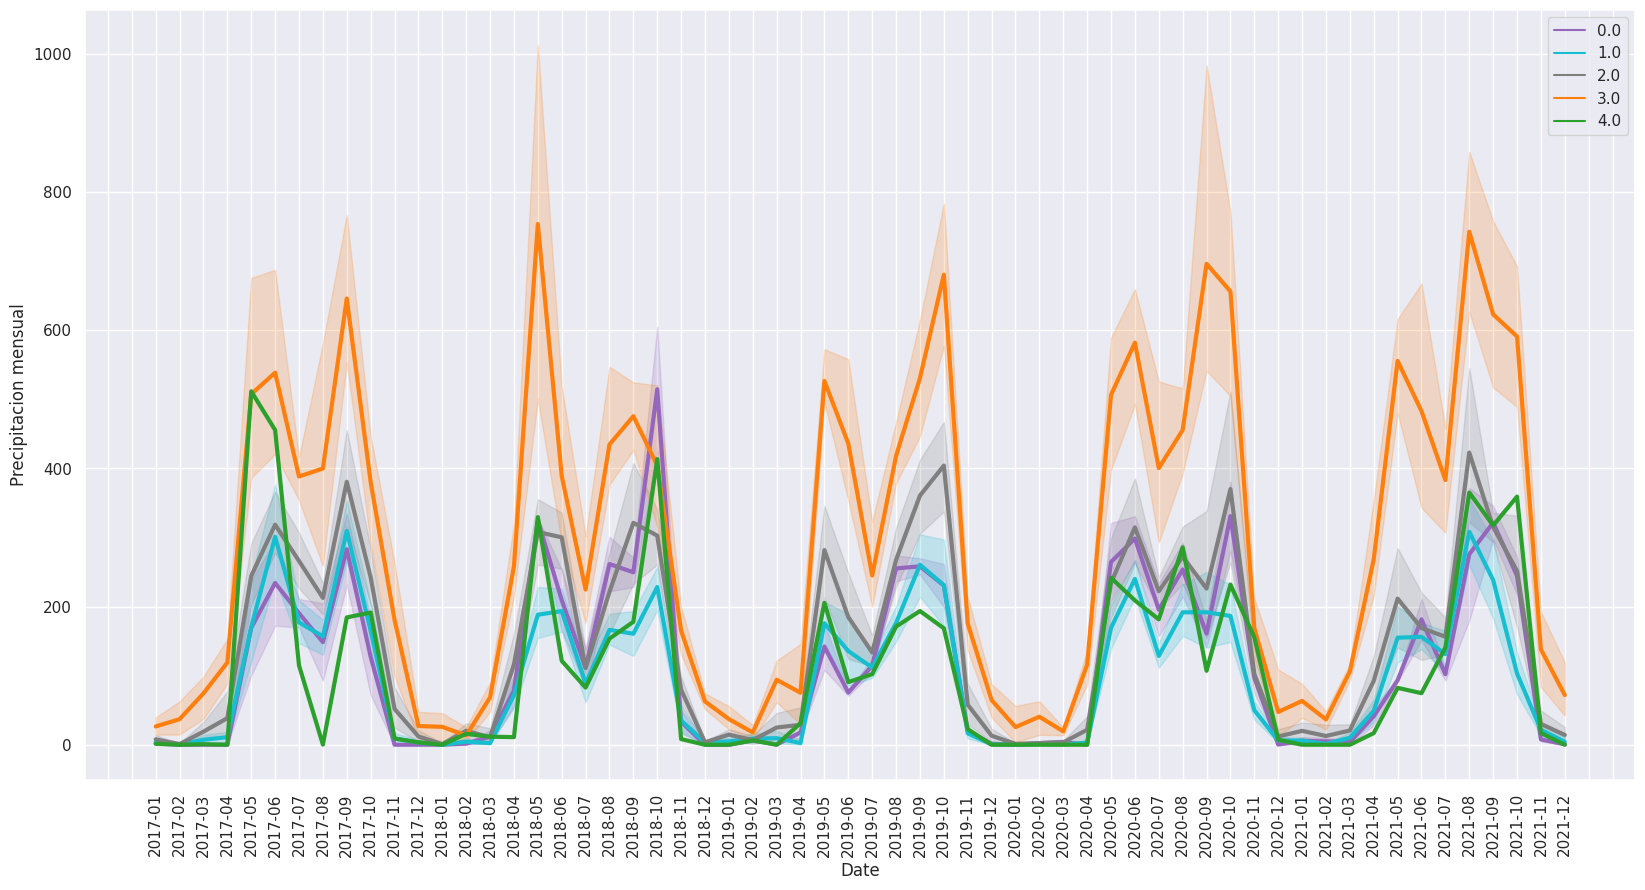

In [69]:
import matplotlib.ticker as ticker
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,10)})

palette = {0: "tab:purple", 1:"tab:cyan", 2: "tab:gray", 3: "tab:orange", 4: "tab:green",  5: "tab:pink"}
ax = sns.lineplot(data=monthly_data,
                  x ='year-month',
                  y = 'prec_sum',
                  hue='cluster', palette=palette,
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Precipitacion mensual')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.show()

In [70]:
monthly_data.head()

estacion year-month month  year  low_monthly_t_min  high_monthly_t_min  \
0   CENCEN    2017-01    01  2017               15.6                21.2   
1   CENCEN    2017-02    02  2017               17.4                22.2   
2   CENCEN    2017-03    03  2017               18.5                22.8   
3   CENCEN    2017-04    04  2017               19.0                23.0   
4   CENCEN    2017-05    05  2017               21.3                23.8   

   high_monthly_t_max  low_monthly_t_max  avg_monthly_avg_t  \
0                33.4               29.0          24.379200   
1                35.4               30.2          25.201004   
2                36.2               29.5          26.113743   
3                35.9               33.3          26.813264   
4                33.8               28.5          26.403931   

   avg_monthly_min_t  avg_monthly_max_t  std_min_t  std_max_t  std_avg_t  \
0          18.361290          31.600000   1.284699   0.852838   0.597137   
1          19.821429          32.485714   1.295679   1.281699   0.561259   
2          20.506452          33.561290   1.116523   1.366669   0.641806   
3          21.180000          34.303333   1.152927   0.666687   0.890760   
4          22.490323          32.087097   0.740880   0.948944   0.597343   

      rad_avg  prec_sum   hume_avg  low_monthly_t_min_date  \
0  214.327957      10.8  75.537970                    1096   
1  214.473445      10.8  75.261161                    1096   
2  234.104335      20.0  74.297043                    1096   
3  246.984167     137.0  76.561458                    1096   
4  203.369657     476.6  87.934812                    1096   

   high_monthly_t_min_date  low_monthly_t_max_date  high_monthly_t_max_date  \
0                      548                     792                     1399   
1                      548                     792                     1399   
2                      548                     792                     1399   
3                      548                     792                     1399   
4                      548                     792                     1399   

   max_no_preci_streak  perc_high_prec    latitud   longitud  altitud  cluster  
0                   17           0.032  14.330962 -91.055468    297.0      3.0  
1                   16           0.036  14.330962 -91.055468    297.0      3.0  
2                   13           0.032  14.330962 -91.055468    297.0      3.0  
3                    6           0.200  14.330962 -91.055468    297.0      3.0  
4                    1           0.548  14.330962 -91.055468    297.0      3.0

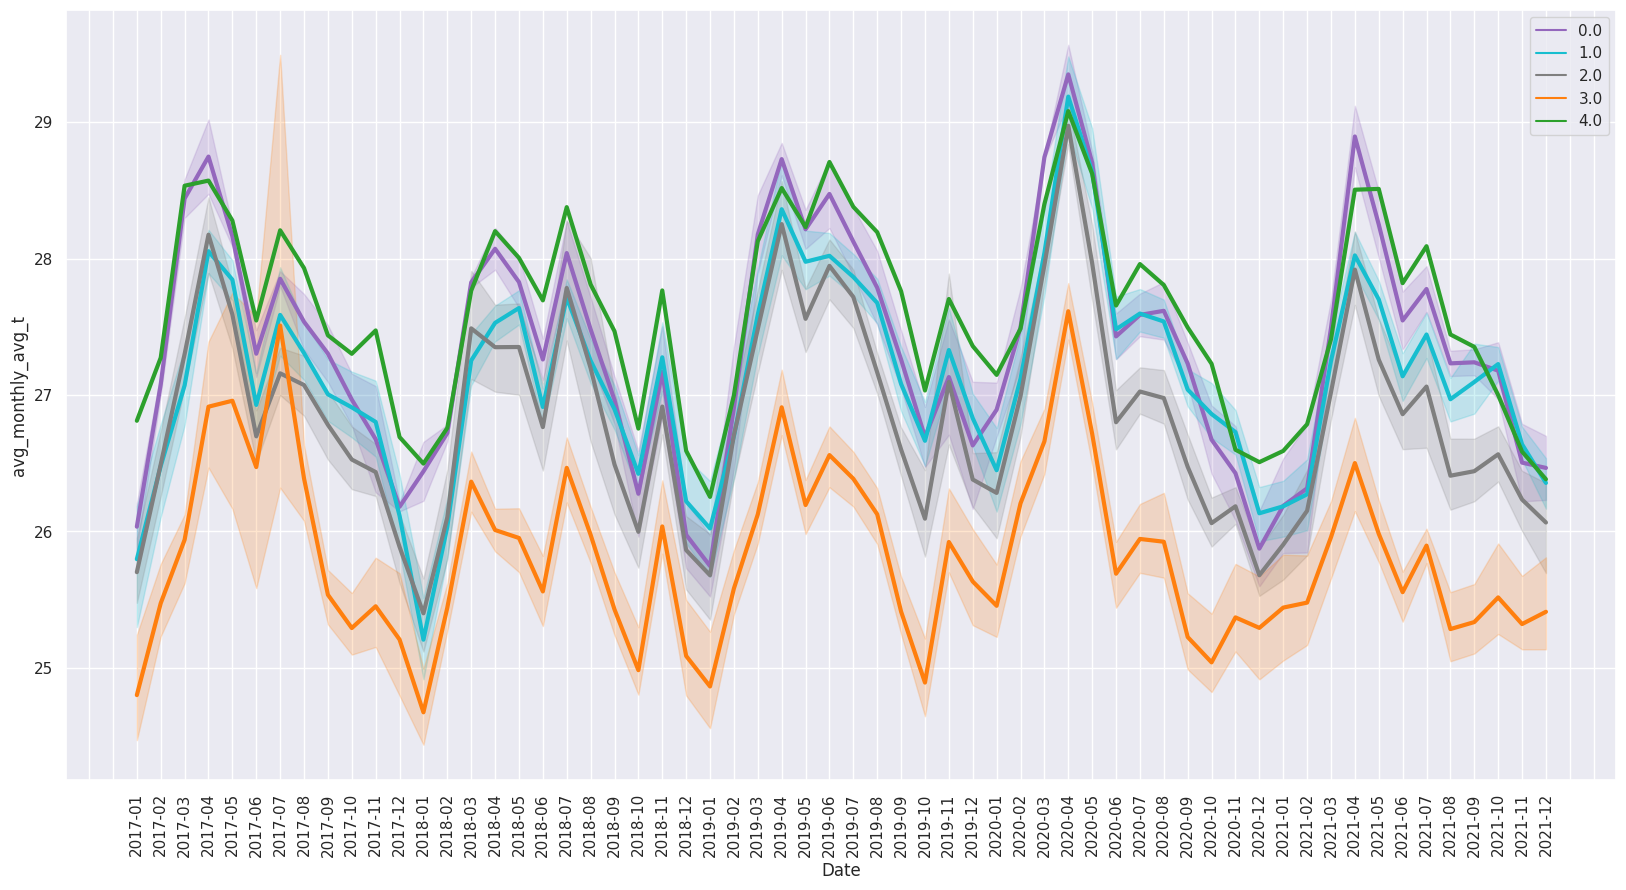

In [71]:
import matplotlib.ticker as ticker
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.lineplot(data=monthly_data,
                  x ='year-month',
                  y = 'avg_monthly_avg_t',
                  hue='cluster', palette=palette,
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('avg_monthly_avg_t')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.show()

sns.barplot(
    data=df, x="body_mass_g", y="island",
    errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

In [72]:
monthly_data.head()

estacion year-month month  year  low_monthly_t_min  high_monthly_t_min  \
0   CENCEN    2017-01    01  2017               15.6                21.2   
1   CENCEN    2017-02    02  2017               17.4                22.2   
2   CENCEN    2017-03    03  2017               18.5                22.8   
3   CENCEN    2017-04    04  2017               19.0                23.0   
4   CENCEN    2017-05    05  2017               21.3                23.8   

   high_monthly_t_max  low_monthly_t_max  avg_monthly_avg_t  \
0                33.4               29.0          24.379200   
1                35.4               30.2          25.201004   
2                36.2               29.5          26.113743   
3                35.9               33.3          26.813264   
4                33.8               28.5          26.403931   

   avg_monthly_min_t  avg_monthly_max_t  std_min_t  std_max_t  std_avg_t  \
0          18.361290          31.600000   1.284699   0.852838   0.597137   
1          19.821429          32.485714   1.295679   1.281699   0.561259   
2          20.506452          33.561290   1.116523   1.366669   0.641806   
3          21.180000          34.303333   1.152927   0.666687   0.890760   
4          22.490323          32.087097   0.740880   0.948944   0.597343   

      rad_avg  prec_sum   hume_avg  low_monthly_t_min_date  \
0  214.327957      10.8  75.537970                    1096   
1  214.473445      10.8  75.261161                    1096   
2  234.104335      20.0  74.297043                    1096   
3  246.984167     137.0  76.561458                    1096   
4  203.369657     476.6  87.934812                    1096   

   high_monthly_t_min_date  low_monthly_t_max_date  high_monthly_t_max_date  \
0                      548                     792                     1399   
1                      548                     792                     1399   
2                      548                     792                     1399   
3                      548                     792                     1399   
4                      548                     792                     1399   

   max_no_preci_streak  perc_high_prec    latitud   longitud  altitud  cluster  
0                   17           0.032  14.330962 -91.055468    297.0      3.0  
1                   16           0.036  14.330962 -91.055468    297.0      3.0  
2                   13           0.032  14.330962 -91.055468    297.0      3.0  
3                    6           0.200  14.330962 -91.055468    297.0      3.0  
4                    1           0.548  14.330962 -91.055468    297.0      3.0

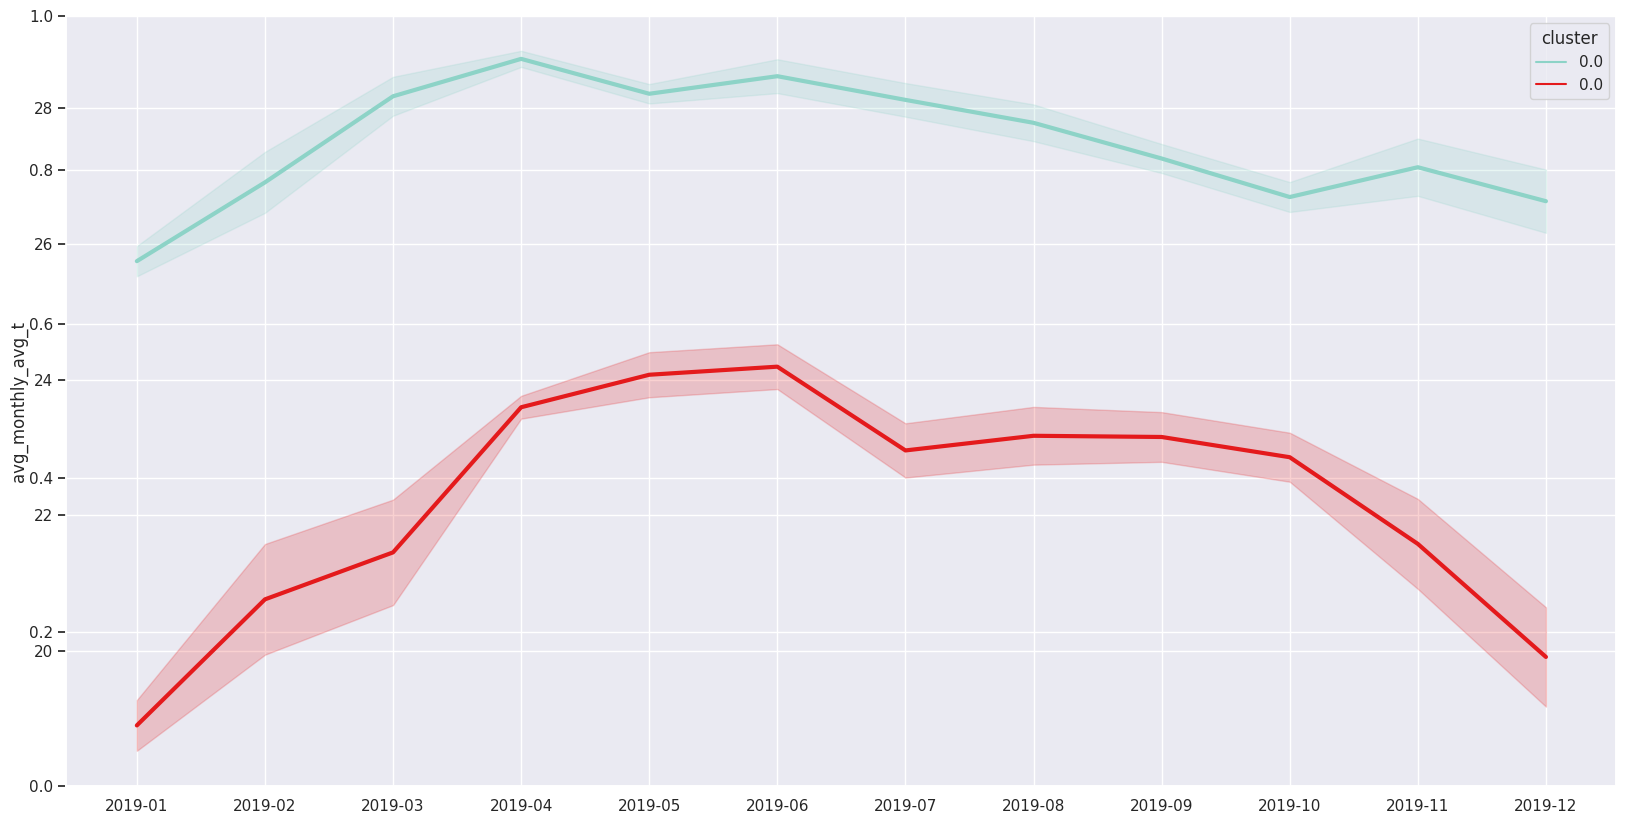

In [73]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

data = monthly_data[(monthly_data.year=='2019')&
                   (monthly_data.cluster==0)]

ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_avg_t',
                  hue='cluster', palette="Set3",
                  legend='full', lw=3)


ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_min_t',
                  hue='cluster', palette="Set1",
                  legend='full', lw=3)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.spines['top'].set_visible(False)

ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()

ax2.spines['top'].set_visible(False)





In [74]:
monthly_data.head()

estacion year-month month  year  low_monthly_t_min  high_monthly_t_min  \
0   CENCEN    2017-01    01  2017               15.6                21.2   
1   CENCEN    2017-02    02  2017               17.4                22.2   
2   CENCEN    2017-03    03  2017               18.5                22.8   
3   CENCEN    2017-04    04  2017               19.0                23.0   
4   CENCEN    2017-05    05  2017               21.3                23.8   

   high_monthly_t_max  low_monthly_t_max  avg_monthly_avg_t  \
0                33.4               29.0          24.379200   
1                35.4               30.2          25.201004   
2                36.2               29.5          26.113743   
3                35.9               33.3          26.813264   
4                33.8               28.5          26.403931   

   avg_monthly_min_t  avg_monthly_max_t  std_min_t  std_max_t  std_avg_t  \
0          18.361290          31.600000   1.284699   0.852838   0.597137   
1          19.821429          32.485714   1.295679   1.281699   0.561259   
2          20.506452          33.561290   1.116523   1.366669   0.641806   
3          21.180000          34.303333   1.152927   0.666687   0.890760   
4          22.490323          32.087097   0.740880   0.948944   0.597343   

      rad_avg  prec_sum   hume_avg  low_monthly_t_min_date  \
0  214.327957      10.8  75.537970                    1096   
1  214.473445      10.8  75.261161                    1096   
2  234.104335      20.0  74.297043                    1096   
3  246.984167     137.0  76.561458                    1096   
4  203.369657     476.6  87.934812                    1096   

   high_monthly_t_min_date  low_monthly_t_max_date  high_monthly_t_max_date  \
0                      548                     792                     1399   
1                      548                     792                     1399   
2                      548                     792                     1399   
3                      548                     792                     1399   
4                      548                     792                     1399   

   max_no_preci_streak  perc_high_prec    latitud   longitud  altitud  cluster  
0                   17           0.032  14.330962 -91.055468    297.0      3.0  
1                   16           0.036  14.330962 -91.055468    297.0      3.0  
2                   13           0.032  14.330962 -91.055468    297.0      3.0  
3                    6           0.200  14.330962 -91.055468    297.0      3.0  
4                    1           0.548  14.330962 -91.055468    297.0      3.0

# Create figure and axis #1
fig, ax1 = plt.subplots()
data = monthly_data[
                   (monthly_data.cluster==0)]

ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_min_t',
                  hue='cluster', palette="Set3",
                  legend='full', lw=3)

ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_max_t',
                  hue='cluster', palette="Set1",
                  legend='full', lw=3)



ax1.set_ylabel('temperature')
ax1.set_ylim(0, 50)
ax1.legend(['average_temp', 'test'], loc="upper left")
ax1.tick_params(axis='x', rotation=90)


# set up the 2nd axis
ax2 = ax1.twinx()
ax2 =sns.barplot(
    data=data, x='year-month', y="prec_sum",hue='cluster', palette = 'purple',alpha= 0.4
)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('average percipitation mm')
ax2.set_ylim(0, 700)
ax2.legend(['average_percipitation_mm'], loc="upper right")
ax2.tick_params(axis='x', rotation=90)




plt.show()

In [75]:
def climatograma(df, cluster):
    # Create figure and axis #1
    fig, ax1 = plt.subplots()
    data = df[(df.cluster==cluster)]
    # tem min
    ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_min_t',
                  hue='cluster', palette="Set3",
                  legend='full', lw=3)
    ax1.legend(['average_temp_min'], loc="upper left")
    # tem max
    ax1 = sns.lineplot(data=data,
                  x ='year-month',
                  y = 'avg_monthly_max_t',
                  hue='cluster', palette="Set1",
                  legend='full', lw=3)
    ax1.set_ylabel('avg_monthly_temperature')
    ax1.set_ylim(0, 45)
    #ax1.legend(['average_temp_max'], loc="lower left")
    ax1.tick_params(axis='x', rotation=90)
    
    # set up the 2nd axis
    ax2 = ax1.twinx()
    ax2 =sns.barplot(
        data=data, x='year-month', y="prec_sum",hue='cluster', alpha= 0.4)
    ax2.grid(False) # turn off grid #2
    ax2.set_ylabel('average percipitation mm')
    ax2.set_ylim(0, 900)
    #ax2.legend(['average_percipitation_mm'], loc="upper right")
    ax2.tick_params(axis='x', rotation=90)
    plt.show()

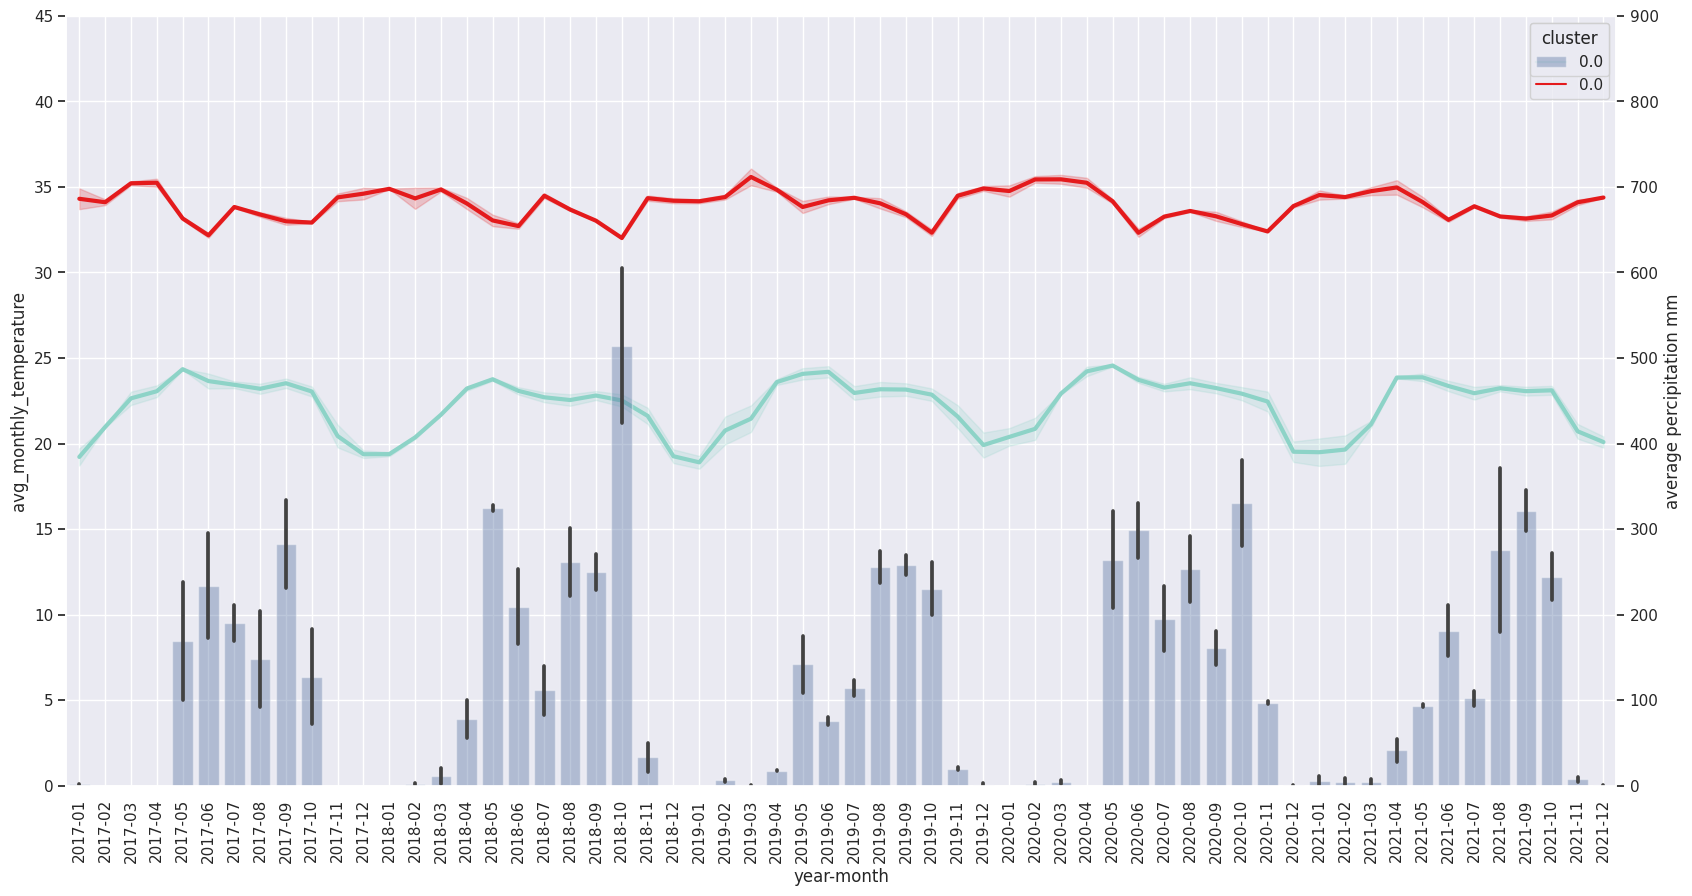

In [76]:
climatograma(monthly_data, 0)

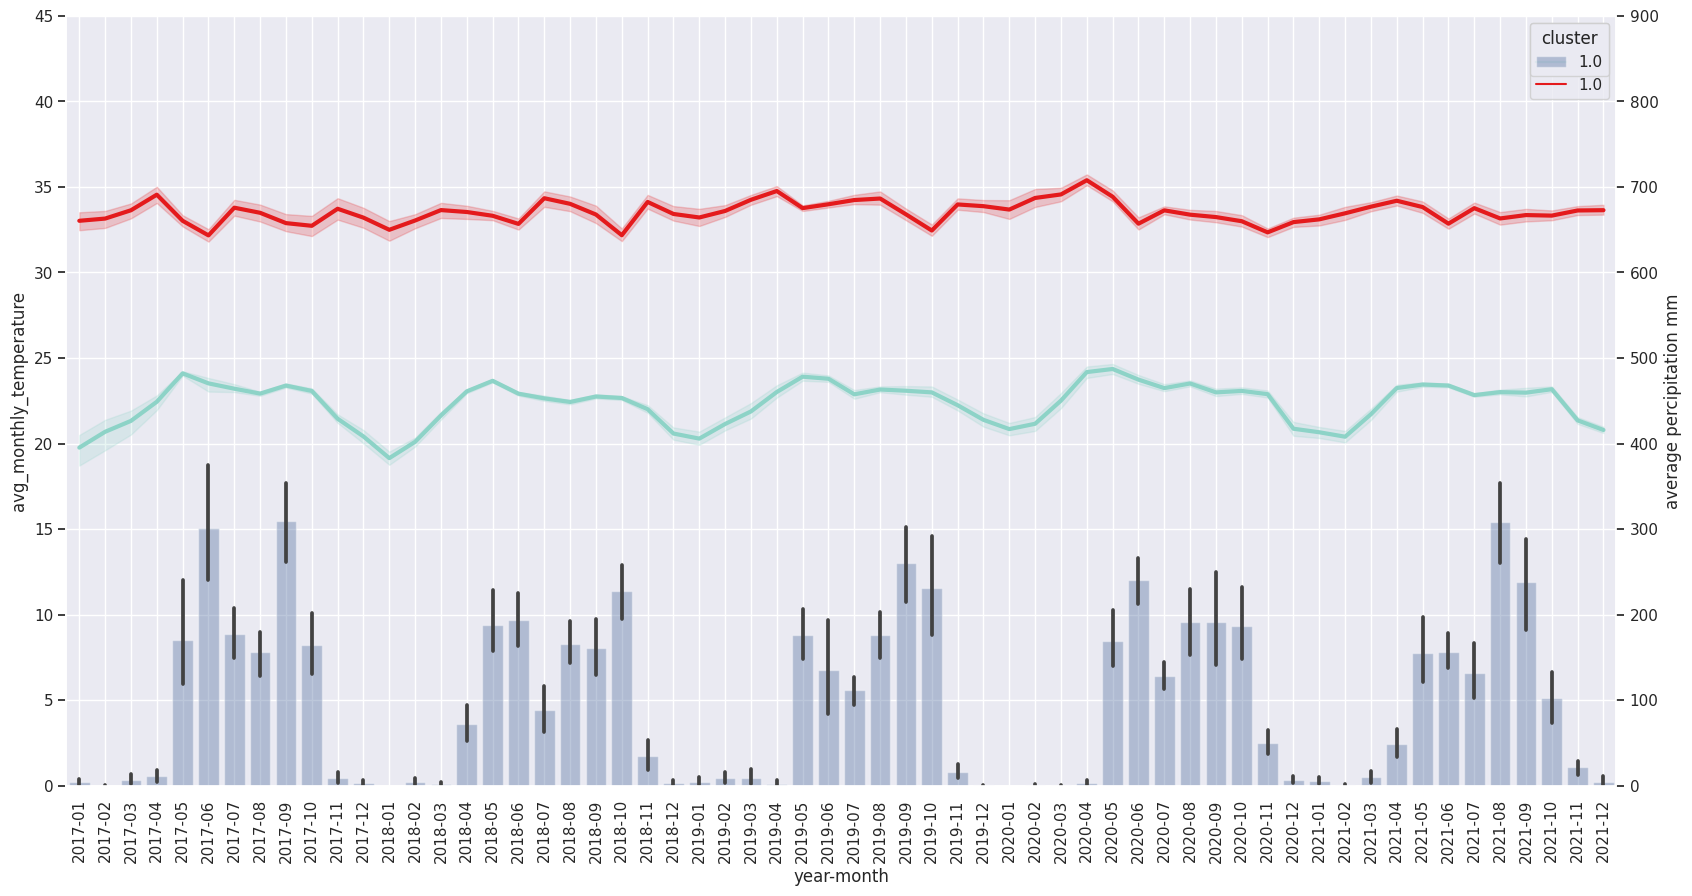

In [77]:
climatograma(monthly_data, 1)

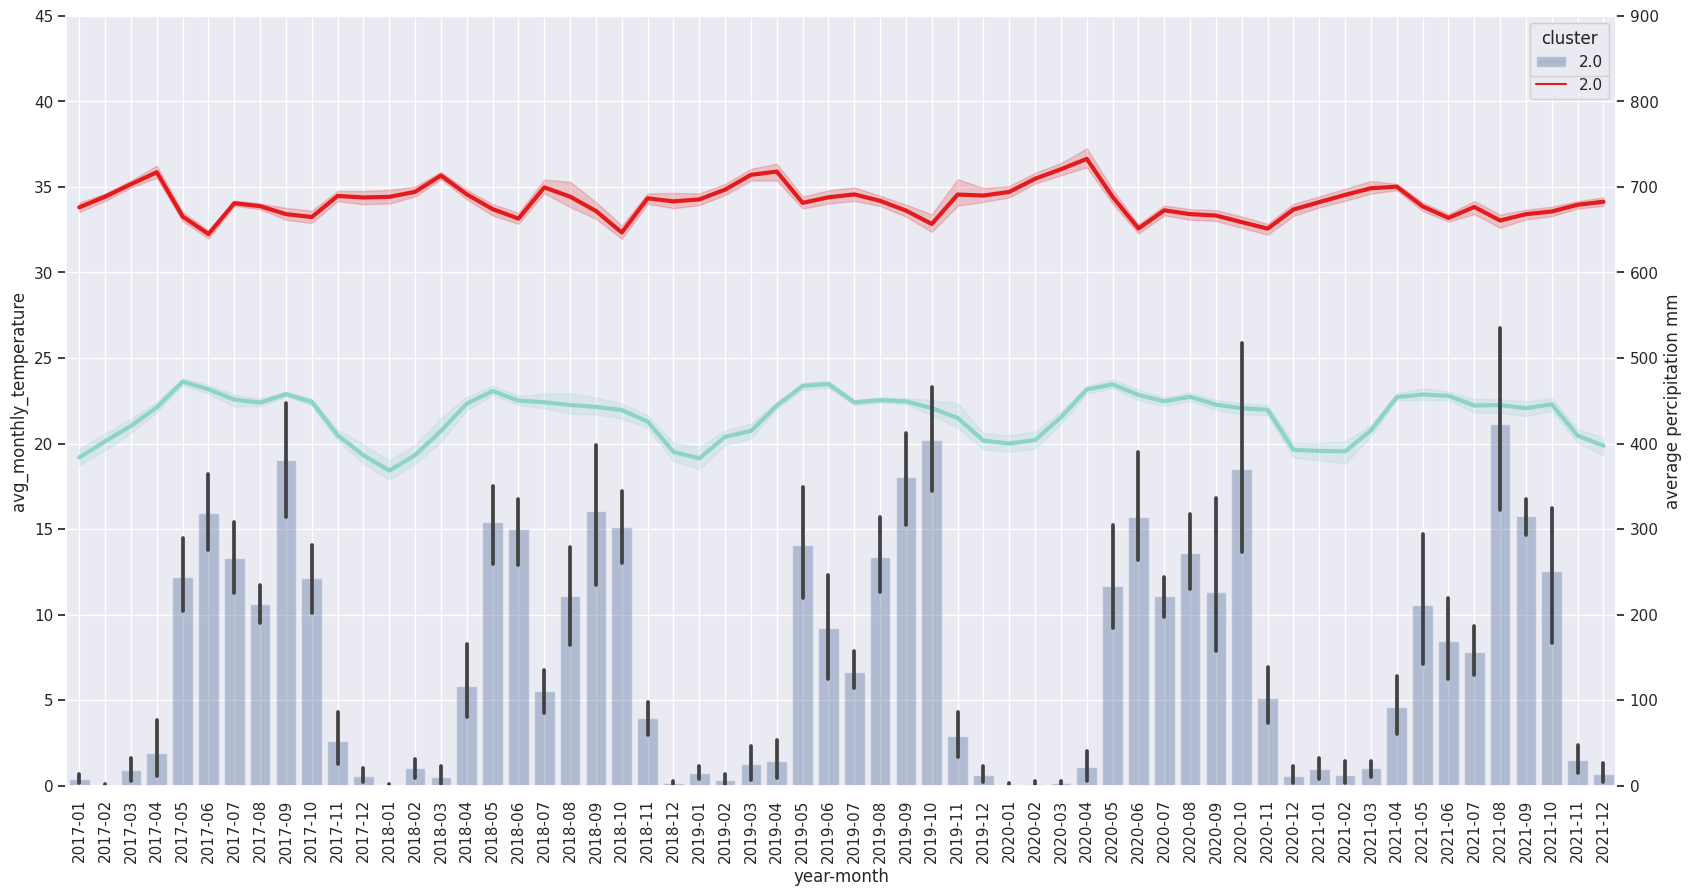

In [78]:
climatograma(monthly_data, 2)

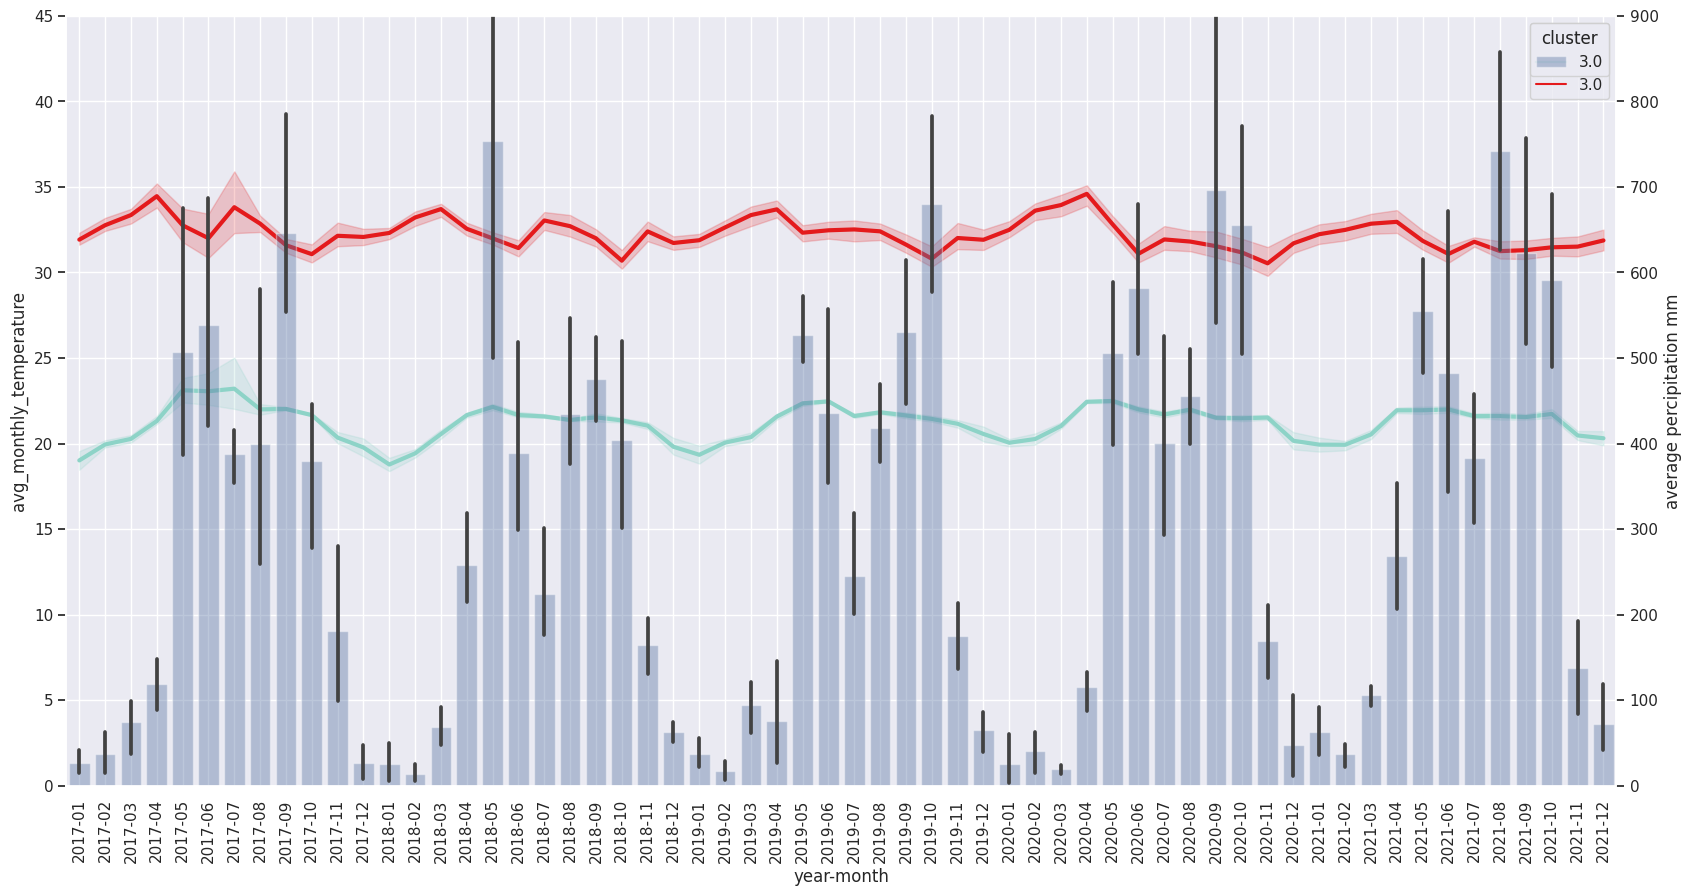

In [79]:
climatograma(monthly_data, 3)

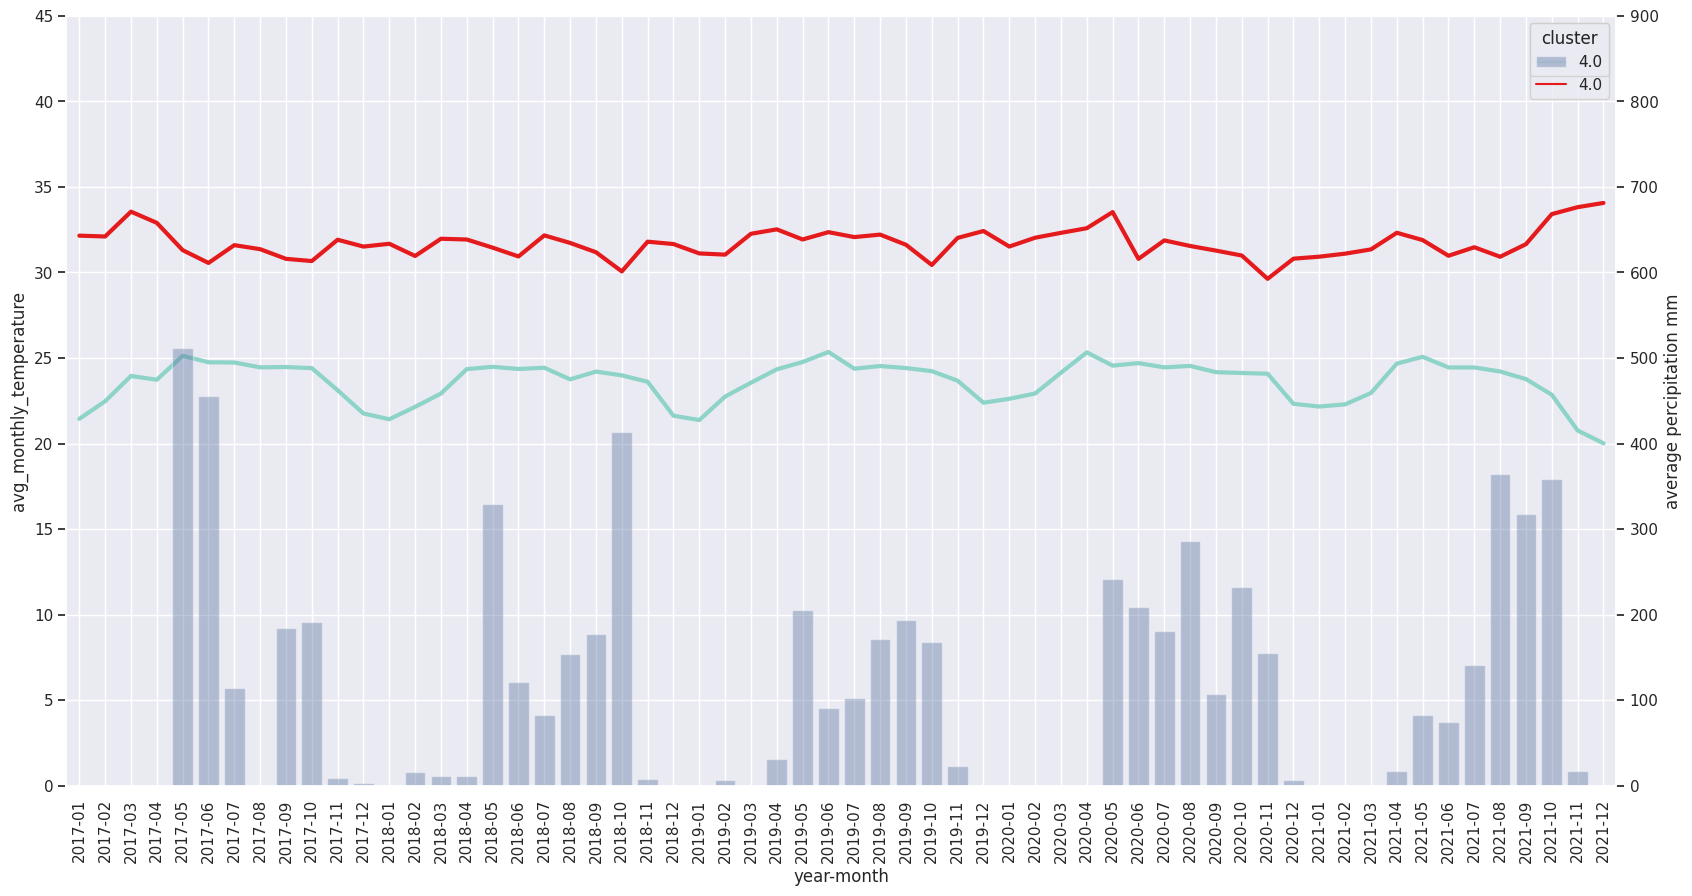

In [80]:
climatograma(monthly_data, 4)

climatograma(monthly_data, 5)

In [81]:
color_type=0
for station in first.estacion.unique():
    print(station)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    first[first.estacion==station].plot(x="month", y="prec_sum",kind='bar', width=0.9, 
                                        ax=ax2, color = colors[color_type],
                                       alpha= 0.4)
    first[first.estacion==station].plot(x="month", y="avg_monthly_avg_t", marker="o",  ax=ax1, color = colors[color_type+1])
    first[first.estacion==station].plot(x="month", y="avg_monthly_min_t", marker="o",  ax=ax1, color = colors[color_type+2])
    first[first.estacion==station].plot(x="month", y="avg_monthly_max_t", marker="o",  ax=ax1, color = colors[color_type+3])
    color_type = color_type +1
    ax2.set_ylim(0,  800)
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    fig.suptitle("Medellin")
    ax2.set_ylabel("Temperatura Promedio (°C)")
    ax1.set_ylabel("Precipitación Promedio (mm)")

    plt.show()

NameError: name 'first' is not defined

In [ ]:
plt.plot(df.index, df["Temperatura Promedio (°C)"],  '-gD', color='red')
ci = 0.1 * np.std(df["Temperatura Promedio (°C)"]) / np.mean(df["Temperatura Promedio (°C)"])
plt.fill_between(df.index, (df["Temperatura Promedio (°C)"]-1.96*ci), (df["Temperatura Promedio (°C)"]+1.96*ci), color='blue', alpha=0.1)
plt.show()

In [ ]:
ci = 0.1 * np.std(df["Temperatura Promedio (°C)"]) / np.mean(df["Temperatura Promedio (°C)"])
ci

In [ ]:
plt.fill_between(df.index, (df["Temperatura Promedio (°C)"]-2*ci), (df["Temperatura Promedio (°C)"]+ci), color='blue', alpha=0.1)

In [ ]:
ci

In [ ]:
for i in col_important:
    plt.figure(figsize = (8,8))
    plt.title(i)
    g=sns.boxplot(x = 'cluster', y =i,palette = "Purples_r" ,showmeans=True,
                data = datos, showfliers=False)
    if i == 'error1-2' or i == 'error1-3'or i == 'error1-4':
        g.set(ylim=(-3, 3))


In [ ]:
datos = pd.concat([datos, features[['estacion', 'xm']]], axis=1)

In [ ]:
datos.columns

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
#my_map.bluemarble()
#my_map.shadedrelief()
my_map.etopo()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.15, 0.85, 6))



#Visualization1
for clust_number in set(s):
    #c=(([0.4,0.4,0.4, 0.4, 0.4, 0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    c= colors[np.int(5)]
    clust_set = datos[datos.cluster == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 40, alpha = 0.65)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=30, color='red',)
        print ("Cluster "+str(clust_number)+', Altitud: '+ str(np.mean(clust_set.altitud)))
plt.title(r"Weather Stations in Canada Clustered (1): $ \epsilon = 0.3$", fontsize=11)        
plt.savefig("etopo_cluster.png", dpi=300)       